In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd

import psycopg2

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook', font_scale=1.2)

import matplotlib.style
matplotlib.style.use('ggplot')
%matplotlib inline

from IPython.display import display

In [2]:
# create a database connection
sqluser = 'mimic'
dbname = 'mimic'
schema_name = 'mimiciii'

cur = None

In [3]:
if cur: 
    cur.close()
    con.close()

con = psycopg2.connect(dbname = dbname, user = sqluser, host='/var/run/postgresql')
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)

In [4]:
query = """
SELECT * FROM icu_features
"""
ef = pd.read_sql_query(query, con)
ef.head()

,icustay_id,hadm_id,subject_id,age,gender,height,weight,bmi,ethnicity,insurance,...,ea_tv_pulm_htn,ea_tv_tr,ea_lv_cavity,ea_lv_diastolic,ea_lv_systolic,ea_lv_wall,ea_rv_cavity,ea_rv_diastolic_fluid,ea_rv_systolic,ea_rv_wall
0,238355,134607,82139,28678 days 18:29:29,M,180.34,38.555351,11.854972,UNKNOWN/NOT SPECIFIED,Medicare,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,274568,151968,65810,16135 days 23:13:48,M,187.96,44.588130,12.620844,WHITE,Medicaid,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,NaN
2,246663,128345,28902,23528 days 12:26:14,M,182.88,80.699997,24.129098,WHITE,Private,...,2.0,1.0,2.0,1.0,3.0,1.0,0.0,NaN,0.0,NaN
3,270608,118555,4734,22639 days 20:28:13,F,NaN,74.000000,NaN,WHITE,Private,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,260990,111727,27334,30774 days 01:32:22,M,167.64,61.800000,21.990402,WHITE,Private,...,NaN,0.0,0.0,1.0,0.0,3.0,0.0,NaN,0.0,NaN


In [5]:
ef.ea_lv_systolic.fillna(-2, inplace=True)

In [6]:
ef.columns.tolist()

['icustay_id',
 'hadm_id',
 'subject_id',
 'age',
 'gender',
 'height',
 'weight',
 'bmi',
 'ethnicity',
 'insurance',
 'ex_congestive_heart_failure',
 'ex_cardiac_aarrhythmias',
 'ex_valvular_disease',
 'ex_pulmonary_circulation',
 'ex_peripheral_vascular',
 'ex_hypertension',
 'ex_paralysis',
 'ex_other_neurological',
 'ex_chronic_pulmonary',
 'ex_diabetes_uncomplicated',
 'ex_diabetes_complicated',
 'ex_hypothyroidism',
 'ex_renal_failure',
 'ex_liver_disease',
 'ex_peptic_ulcer',
 'ex_aids',
 'ex_lymphoma',
 'ex_metastatic_cancer',
 'ex_solid_tumor',
 'ex_rheumatoid_arthritis',
 'ex_coagulopathy',
 'ex_obesity',
 'ex_weight_loss',
 'ex_fluid_electrolyte',
 'ex_blood_loss_anemia',
 'ex_deficiency_anemias',
 'ex_alcohol_abuse',
 'ex_drug_abuse',
 'ex_psychoses',
 'ex_depression',
 'apsiii',
 'apsiii_prob',
 'apsiii_creatinine_score',
 'admittime',
 'dischtime',
 'intime',
 'outtime',
 'dod',
 'creatinine_last',
 'creatinine_max',
 'lactate_last',
 'lactate_max',
 'lab_albumin',
 'lab

In [7]:
len(ef)

61532

In [8]:
## apply filters
F = (ef['filter_vaso'] | ef['filter_angus_sepsis']) \
        & ef['filter_micu'] \
        & ~ef['filter_hard_cardiogenic'] \
        & ~ef['filter_chronic_dialysis'] \
        & ef['filter_adult']

In [9]:
ef = ef.loc[F]
len(ef)

9681

-4.0 3854.0
94
687
count    2293.000000
mean      299.054950
std       571.612701
min        -4.000000
25%         0.000000
50%        30.000000
75%       305.000000
max      3854.000000
dtype: float64


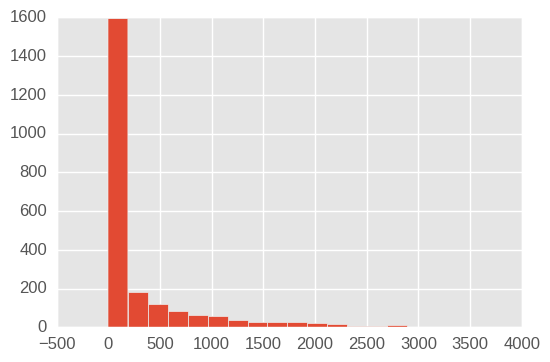

In [10]:
plot_data = ef.ea_days_after_discharge_death.values
plot_data = plot_data[~np.isnan(plot_data)]
plt.hist(plot_data, bins=20)
print(plot_data.min(), plot_data.max())
print(np.sum(plot_data < 0)) # only 324 out of 10k died before discharge???
print(np.sum(plot_data == 0)) # 2512 died at 0 minutes after discharge???
print(pd.Series(plot_data).describe())

In [60]:
#day30_mortality = ef.ea_days_after_discharge_death <= 30
day30_mortality = (ef.dod - ef.intime) < np.timedelta64(30, 'D')

In [61]:
day30_mortality.value_counts()

False    6911
True     2770
dtype: int64

In [62]:
ef['day30_mortality'] = day30_mortality

In [63]:
#ef.groupby(['day30_mortality', 'mech_vent']).size().unstack()

In [64]:
#ef.groupby(['day30_mortality', 'noninv_vent']).size().unstack()

In [65]:
%%bash
cat ../resources/lv_systolic.txt

====-1
Hyperdynamic LVEF >75%
Hyperdynamic LVEF
Left ventricular systolic function is hyperdynamic (EF>75%)
Hyperdynamic left ventricular systolic function
Hyperdynamic LVEF (>75%)
====0
Overall normal LVEF (>55%)
Normal LV wall thickness, cavity size and regional/global systolic function (LVEF >55%)
Low normal LVEF
Normal LV wall thickness, cavity size, and systolic function (LVEF>55%)
Mild symmetric LVH with normal cavity size and regional/global systolic function (LVEF>55%)
Overall left ventricular systolic function is normal (LVEF>55%)
Normal LV wall thickness, cavity size, and global systolic function (LVEF>55%)
Left ventricular wall thickness, cavity size, and systolic function are normal (LVEF>55%)
Mild symmetric LVH with normal cavity size and systolic function (LVEF>55%)
Mild symmetric LVH with normal cavity size and global systolic function (LVEF>55%)
Overall left ventricular systolic function is low normal (LVEF 50-55%)
There is mild symmetric left ventricular hypertrophy wi

In [72]:
table = ef.groupby(['day30_mortality', 'filter_echo']).size().unstack()
table

filter_echo,False,True
day30_mortality,,
False,4107,2804
True,1604,1166


In [73]:
table = ef.groupby(['day30_mortality', 'filter_echo']).size().unstack()
table /= table.sum(axis=0)
table

filter_echo,False,True
day30_mortality,,
False,0.719139,0.706297
True,0.280861,0.293703


In [74]:
table = ef.groupby(['day30_mortality', 'ea_lv_systolic']).size().unstack()
table

ea_lv_systolic,-50.0,-2.0,-1.0,0.0,1.0,2.0,3.0
day30_mortality,,,,,,,
False,17,4678,158,1609,184,100,165
True,8,1873,111,540,75,54,109


In [75]:
table = ef.groupby(['day30_mortality', 'ea_lv_systolic']).size().unstack()
table /= table.sum(axis=0)
table ## severely depressed and hyperdynamic have increased likelihood of death

ea_lv_systolic,-50.0,-2.0,-1.0,0.0,1.0,2.0,3.0
day30_mortality,,,,,,,
False,0.68,0.714089,0.587361,0.74872,0.710425,0.649351,0.60219
True,0.32,0.285911,0.412639,0.25128,0.289575,0.350649,0.39781


In [76]:
table = ef.groupby(['day30_mortality', 'ex_congestive_heart_failure']).size().unstack()
table

ex_congestive_heart_failure,0,1
day30_mortality,,
False,4770,2141
True,1827,943


In [77]:
table = ef.groupby(['day30_mortality', 'ex_congestive_heart_failure']).size().unstack()
table /= table.sum(axis=0)
table

ex_congestive_heart_failure,0,1
day30_mortality,,
False,0.723056,0.694228
True,0.276944,0.305772


In [78]:
for name,group in ef.groupby('ex_congestive_heart_failure'):
    table = group.groupby(['day30_mortality', 'ea_lv_systolic']).size().unstack()
    #table /= table.sum(axis=0)
    print('Congestive heart failure =', name)
    display(table)

Congestive heart failure = 0


ea_lv_systolic,-50.0,-2.0,-1.0,0.0,1.0,2.0,3.0
day30_mortality,,,,,,,
False,9,3364,110,1115,84,39,49
True,5,1277,80,367,42,16,40


Congestive heart failure = 1


ea_lv_systolic,-50.0,-2.0,-1.0,0.0,1.0,2.0,3.0
day30_mortality,,,,,,,
False,8,1314,48,494,100,61,116
True,3,596,31,173,33,38,69


In [79]:
for name,group in ef.groupby('ex_congestive_heart_failure'):
    table = group.groupby(['day30_mortality', 'ea_lv_systolic']).size().unstack()
    table /= table.sum(axis=0)
    print('Congestive heart failure =', name)
    display(table)

Congestive heart failure = 0


ea_lv_systolic,-50.0,-2.0,-1.0,0.0,1.0,2.0,3.0
day30_mortality,,,,,,,
False,0.642857,0.724844,0.578947,0.752362,0.666667,0.709091,0.550562
True,0.357143,0.275156,0.421053,0.247638,0.333333,0.290909,0.449438


Congestive heart failure = 1


ea_lv_systolic,-50.0,-2.0,-1.0,0.0,1.0,2.0,3.0
day30_mortality,,,,,,,
False,0.727273,0.687958,0.607595,0.74063,0.75188,0.616162,0.627027
True,0.272727,0.312042,0.392405,0.25937,0.24812,0.383838,0.372973


count     6923.000000
mean       621.206694
std       2344.437551
min     -32273.750000
25%       -381.360405
50%        167.577853
75%       1250.562500
max      22650.240544
dtype: float64


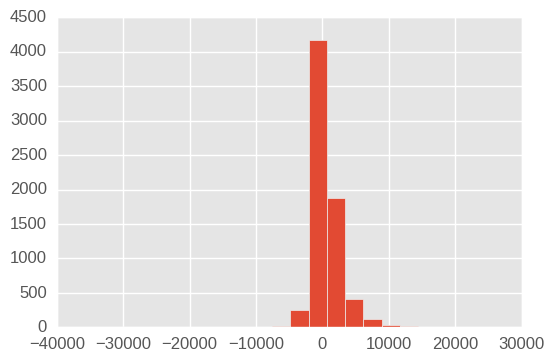

In [80]:
plot_data = ef.fb_day1_balance_ml.values
plot_data = plot_data[~np.isnan(plot_data)]
print(pd.Series(plot_data).describe())
_ = plt.hist(plot_data, bins=20)

-2.0     6551
 0.0     2149
 3.0      274
-1.0      269
 1.0      259
 2.0      154
-50.0      25
Name: ea_lv_systolic, dtype: int64

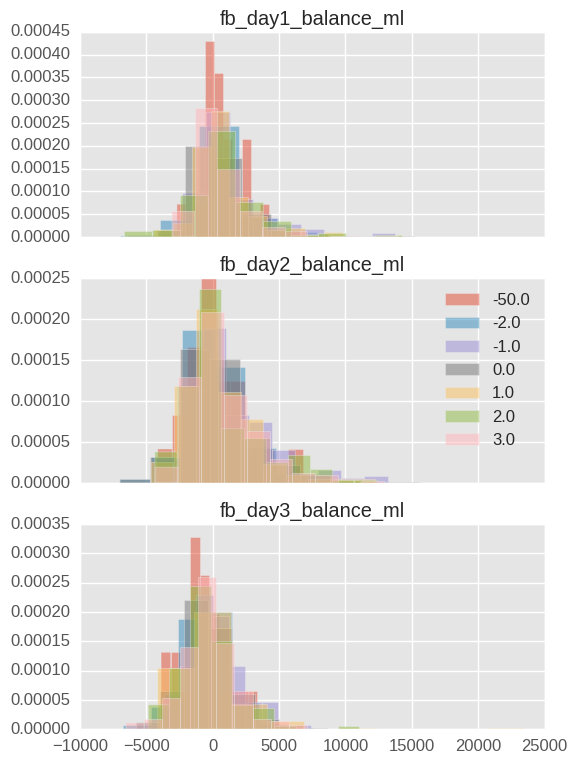

In [81]:
## if we group by echo lv systolic, what do the fluid distributions look like?
display(ef.ea_lv_systolic.value_counts())
fig, axs = plt.subplots(3, sharex=True, figsize=(6, 9))
for i,fluid_day in enumerate(['fb_day1_balance_ml', 'fb_day2_balance_ml', 'fb_day3_balance_ml']):
    ax = axs[i]
    for name,group in ef.groupby('ea_lv_systolic'):
        fluid = group[fluid_day].values.copy()
        # filter out less than -7 litres
        fluid[fluid < -7000] = np.nan
        fluid = fluid[~np.isnan(fluid)]
        ax.hist(fluid, alpha=0.5, label=str(name), normed=True)
    ax.set_title(fluid_day)
    if i == 1:
        ax.legend(loc='best')

## Fluid management following echo by LV systolic

In [82]:
to_plot = ef[['fb_day1_balance_ml', 'fb_day2_balance_ml', 'fb_day3_balance_ml']].stack().reset_index()
to_plot.columns = ['row_id', 'Day', 'Fluid balance (ml)']
to_plot.loc[to_plot['Day'] == 'fb_day1_balance_ml', 'Day'] = 1
to_plot.loc[to_plot['Day'] == 'fb_day2_balance_ml', 'Day'] = 2
to_plot.loc[to_plot['Day'] == 'fb_day3_balance_ml', 'Day'] = 3
to_plot = to_plot.loc[to_plot['Fluid balance (ml)'] >= -7000]
to_plot = pd.merge(to_plot, ef[['ea_lv_systolic']], left_on = 'row_id', right_index = True)
to_plot = pd.merge(to_plot, ef[['ex_congestive_heart_failure']], left_on = 'row_id', right_index = True)
to_plot = pd.merge(to_plot, ef[['day30_mortality']], left_on='row_id', right_index=True)
to_plot = pd.merge(to_plot, ef[['filter_echo']], left_on='row_id', right_index=True)
#to_plot = pd.merge(to_plot, ef[['mech_vent']], left_on='row_id', right_index=True)

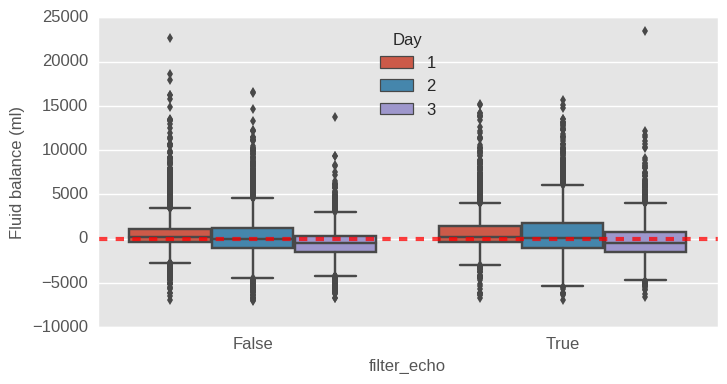

In [83]:
plt.figure(figsize=(8, 4))
sns.boxplot(data = to_plot, x = 'filter_echo', y = 'Fluid balance (ml)', hue = 'Day')
plt.plot([-100, 100], [0, 0], '--r', linewidth=3, alpha=0.75)

In [84]:
from scipy.stats import ttest_ind
group_0 = ef.loc[~ef.filter_echo].fb_day1_balance_ml.dropna()
group_1 = ef.loc[ef.filter_echo].fb_day1_balance_ml.dropna()
print(group_0.mean(), group_1.mean())
print(group_0.std(), group_1.std())
ttest_ind(group_0, group_1, equal_var=True)

552.774698184 714.963915738
2315.26317182 2381.03531731


Ttest_indResult(statistic=-2.8442171762402948, pvalue=0.004465127846819187)

(-5000, 10000)

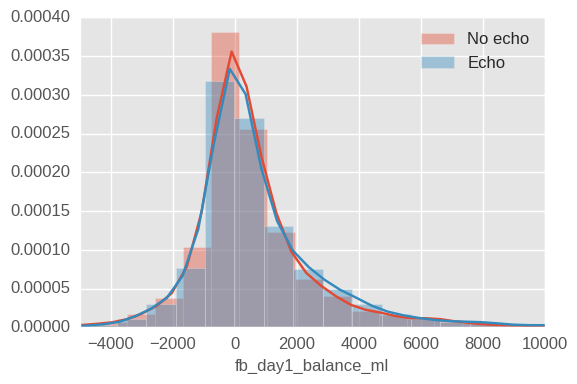

In [85]:
sns.distplot(group_0, label='No echo')
sns.distplot(group_1, label='Echo')
plt.legend()
plt.xlim((-5000, 10000))

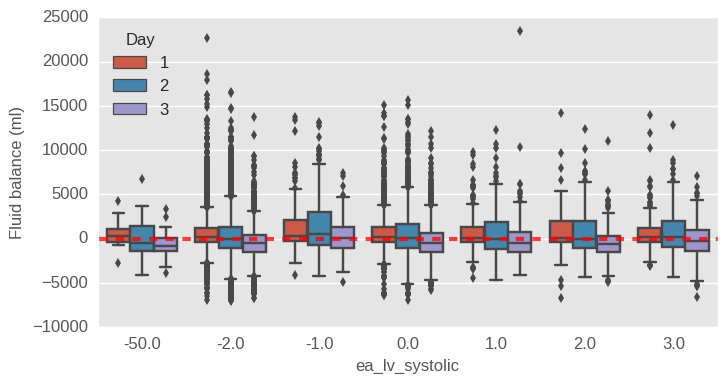

In [86]:
plt.figure(figsize=(8, 4))
sns.boxplot(data = to_plot, x = 'ea_lv_systolic', y = 'Fluid balance (ml)', hue = 'Day')
plt.plot([-100, 100], [0, 0], '--r', linewidth=3, alpha=0.75)

In [87]:
from scipy.stats import ttest_ind
group_0 = ef.loc[ef.ea_lv_systolic == 0].fb_day1_balance_ml.dropna()
group_1 = ef.loc[ef.ea_lv_systolic == 3].fb_day1_balance_ml.dropna()
print(group_0.mean(), group_1.mean())
print(group_0.std(), group_1.std())
ttest_ind(group_0, group_1, equal_var=True)

676.567859985 701.799015247
2207.10216913 2250.40499669


Ttest_indResult(statistic=-0.14834941196411427, pvalue=0.8820837029264651)

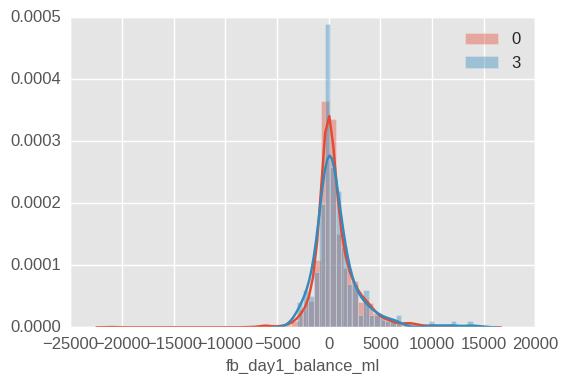

In [88]:
sns.distplot(group_0, label='0')
sns.distplot(group_1, label='3')
plt.legend()

In [89]:
from scipy.stats import ttest_ind
from scipy.stats import pearsonr

## Fluid management by LV systolic and 30-day mortality

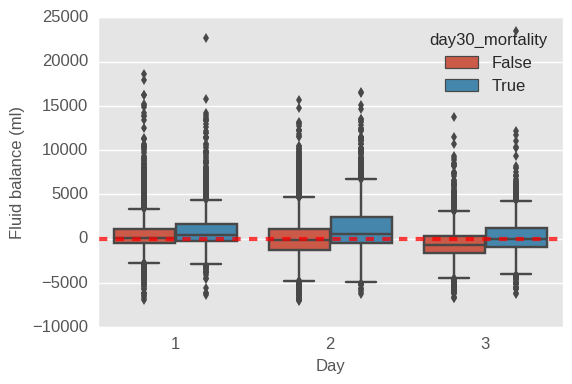

In [97]:
g = sns.boxplot(data=to_plot, x='Day', y='Fluid balance (ml)', hue='day30_mortality')
_ = plt.plot([-100, 100], [0, 0], '--r', linewidth=3, alpha=0.75)

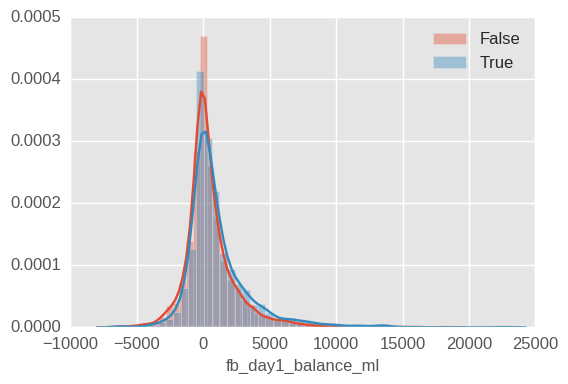

506.223802122 2017.60552028
1067.33346312 2429.20377972
Ttest_indResult(statistic=-9.1110918956579692, pvalue=1.412092351295115e-19)
0.117736824456 9.824881564e-23


In [98]:
filter = (ef.fb_day1_balance_ml >= -7000)
group_0 = ef.loc[filter & (ef.day30_mortality == False)].fb_day1_balance_ml
group_0 = group_0.dropna()
group_1 = ef.loc[filter & (ef.day30_mortality == True)].fb_day1_balance_ml
group_1 = group_1.dropna()

f = plt.figure()
sns.distplot(group_0, label='False')
sns.distplot(group_1, label='True')
plt.legend()
display(f)
plt.close()
print(group_0.mean(), group_0.std())
print(group_1.mean(), group_1.std())

stats = {}
ttest = ttest_ind(group_0, group_1, equal_var=False)
print(ttest)
stats['t-test p-value'] = ttest.pvalue
data = ef.loc[filter,['fb_day1_balance_ml', 'day30_mortality']].dropna()
r, pval = pearsonr(data.fb_day1_balance_ml, data.day30_mortality)
print(r, pval)

In [100]:
table = ef.groupby(['day30_mortality', 'filter_echo']).size().unstack()
table

filter_echo,False,True
day30_mortality,,
False,4107,2804
True,1604,1166


In [102]:
table = ef.groupby(['day30_mortality', 'filter_echo']).size().unstack()
table /= table.sum(0)
table

filter_echo,False,True
day30_mortality,,
False,0.719139,0.706297
True,0.280861,0.293703


In [103]:
counts = ef.groupby('ea_lv_systolic').apply(lambda x: x['day30_mortality'].value_counts())
counts = counts.T
counts.index.name = 'day30_mortality'
counts

ea_lv_systolic,-50.0,-2.0,-1.0,0.0,1.0,2.0,3.0
day30_mortality,,,,,,,
False,17,4678,158,1609,184,100,165
True,8,1873,111,540,75,54,109


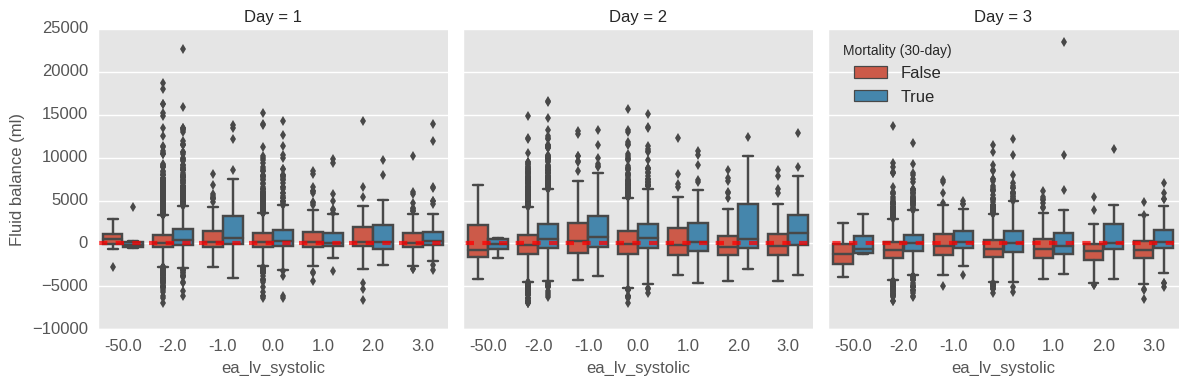

In [104]:
g  = sns.factorplot(data=to_plot, x='ea_lv_systolic', y='Fluid balance (ml)', kind='box', legend=False
               #, hue='Day', col='ex_congestive_heart_failure')
               , hue='day30_mortality', col='Day')
for ax in g.axes.ravel():
    ax.plot([-100, 100], [0, 0], '--r', linewidth=3, alpha=0.75)
plt.legend(loc='best', title='Mortality (30-day)')

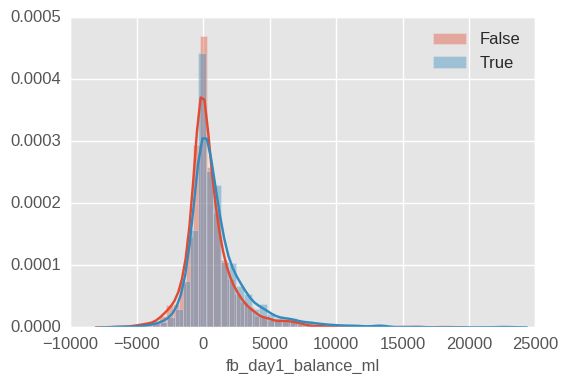

LV systolic: -2
453.878510268 1988.61942478
1064.58572017 2386.56702769
Ttest_indResult(statistic=-8.2042054313289938, pvalue=4.0134565711635061e-16)
0.129805442231 1.1097148607e-18



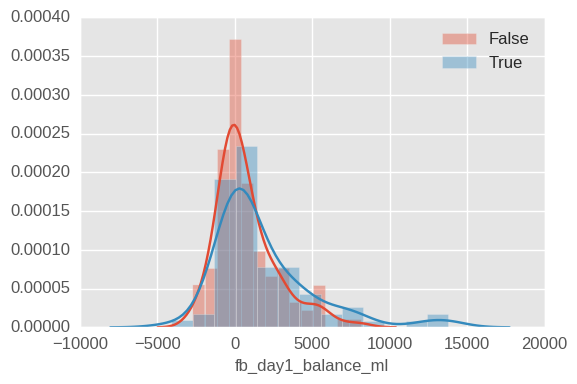

LV systolic: -1
752.499935248 1970.79247549
1834.2489865 3226.4688386
Ttest_indResult(statistic=-2.7314350152466513, pvalue=0.0072065532553085253)
0.204286551216 0.00354258770255



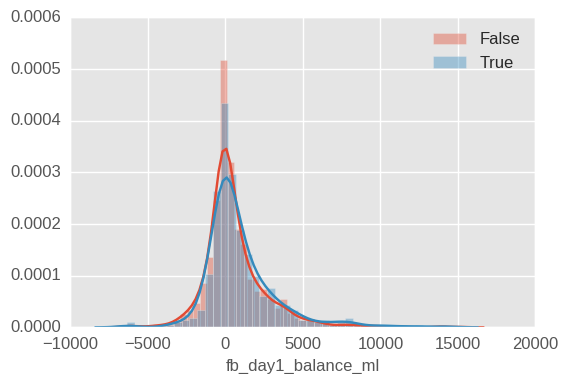

LV systolic: 0
600.612176503 2059.47747826
960.065696314 2302.55280692
Ttest_indResult(statistic=-2.8283484788110838, pvalue=0.0048174275653388027)
0.0742846512783 0.00291186322144



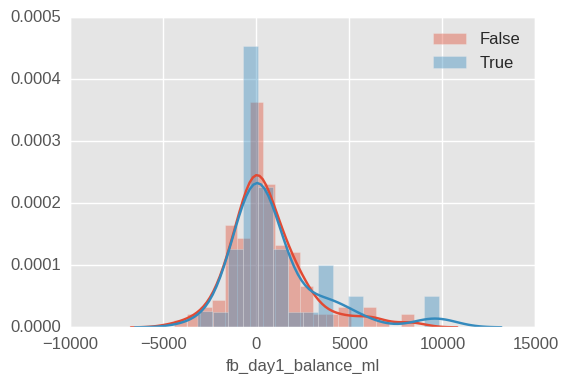

LV systolic: 1
605.247733662 2087.51507632
984.52166827 2476.98366816
Ttest_indResult(statistic=-0.95497279795775358, pvalue=0.34268572044757462)
0.0766168540318 0.302602841288



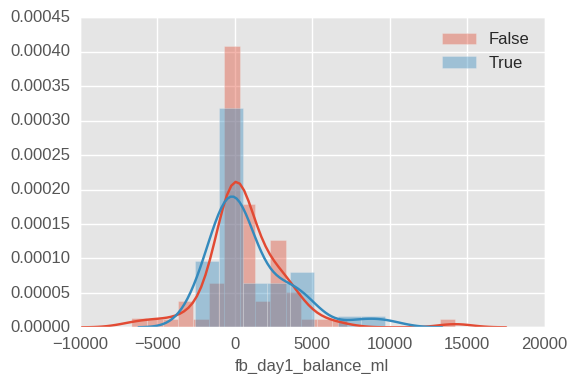

LV systolic: 2
709.297731577 2642.07594875
978.676506184 2603.81982958
Ttest_indResult(statistic=-0.53478868136843005, pvalue=0.59424070681531838)
0.0489438050561 0.595516510948



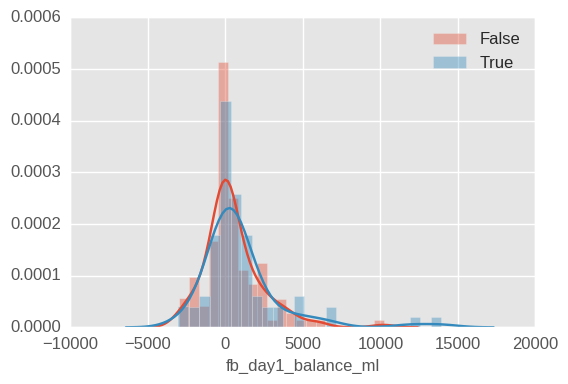

LV systolic: 3
507.722446757 1914.5533414
1003.40449331 2677.04850317
Ttest_indResult(statistic=-1.3815940579515191, pvalue=0.16965065020761549)
0.107794712626 0.139834780713



,LV systolic,Pearson r,t-test p-value
0,-2,0.129805,4.013457e-16
1,-1,0.204287,7.206553e-03
2,0,0.074285,4.817428e-03
3,1,0.076617,3.426857e-01
4,2,0.048944,5.942407e-01
5,3,0.107795,1.696507e-01


In [106]:
statistics = []
for systolic_flag in [-2, -1, 0, 1, 2, 3]:
    filter = (ef.ea_lv_systolic == systolic_flag) & (ef.fb_day1_balance_ml >= -7000)
    group_0 = ef.loc[filter & (ef.day30_mortality == False)].fb_day1_balance_ml
    group_0 = group_0.dropna()
    group_1 = ef.loc[filter & (ef.day30_mortality == True)].fb_day1_balance_ml
    group_1 = group_1.dropna()

    f = plt.figure()
    sns.distplot(group_0, label='False')
    sns.distplot(group_1, label='True')
    plt.legend()
    display(f)
    plt.close()
    print('LV systolic:', systolic_flag)
    print(group_0.mean(), group_0.std())
    print(group_1.mean(), group_1.std())

    stats = {}
    ttest = ttest_ind(group_0, group_1, equal_var=False)
    print(ttest)
    stats['t-test p-value'] = ttest.pvalue
    data = ef.loc[filter,['fb_day1_balance_ml', 'day30_mortality']].dropna()
    r, pval = pearsonr(data.fb_day1_balance_ml, data.day30_mortality)
    print(r, pval)
    stats['Pearson r'] = r
    stats['LV systolic'] = systolic_flag
    statistics.append(stats)
    print('')
statistics = pd.DataFrame(statistics)
statistics

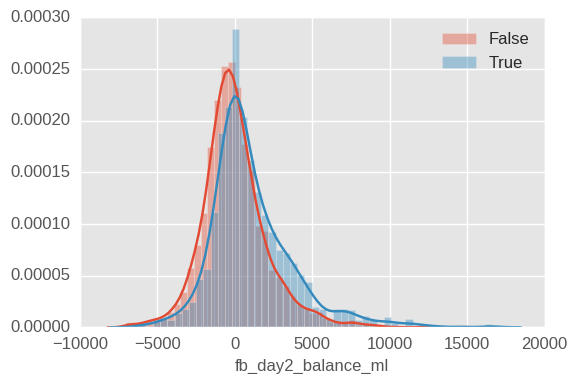

LV systolic: -2
15.0061671896 2128.47206442
1103.31317386 2683.11336215
Ttest_indResult(statistic=-14.3791326836756, pvalue=5.5595563635815489e-45)
0.207040319264 5.10733907018e-56



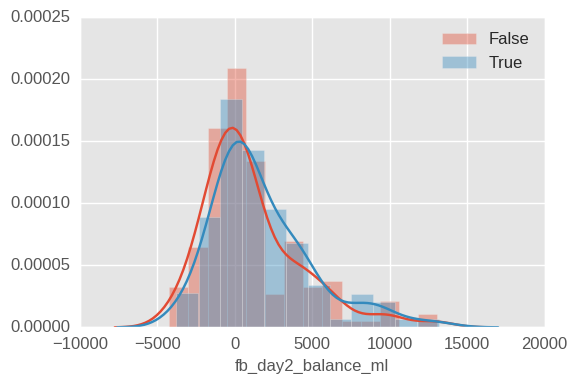

LV systolic: -1
1110.80716302 3212.36968844
1741.65971986 3239.88958992
Ttest_indResult(statistic=-1.5333313633151346, pvalue=0.12662880205519439)
0.0961050787813 0.125848440066



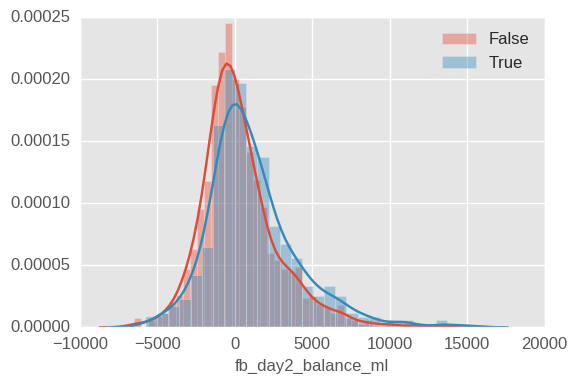

LV systolic: 0
333.390091267 2531.86550104
1164.33682247 2890.8650171
Ttest_indResult(statistic=-5.7147348854874931, pvalue=1.5786829142342877e-08)
0.135409900063 1.20219378335e-09



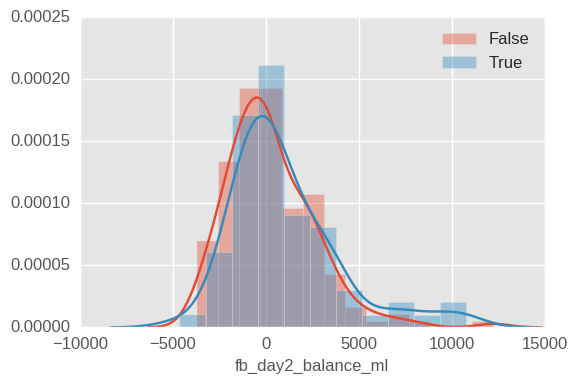

LV systolic: 1
291.944901727 2393.93019148
1043.85520579 2918.59080997
Ttest_indResult(statistic=-1.9103546550617212, pvalue=0.058630744773562421)
0.134072775667 0.0400126473558



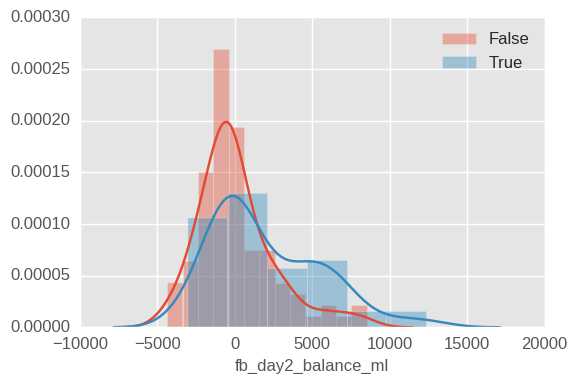

LV systolic: 2
103.974779477 2490.09909044
2034.25348511 3498.40368221
Ttest_indResult(statistic=-3.4072855776633935, pvalue=0.0010770438256494071)
0.305289650858 0.000220415852625



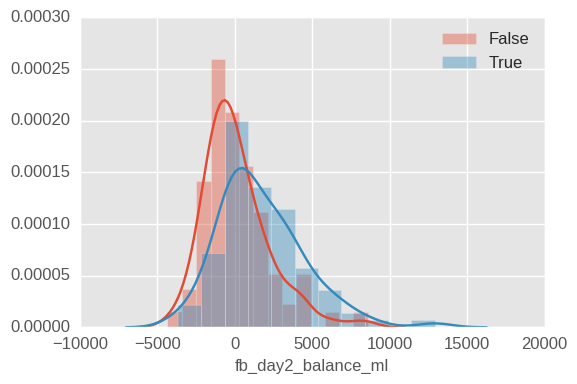

LV systolic: 3
119.186307312 2145.04328672
1732.54541753 2790.65701401
Ttest_indResult(statistic=-4.7522794808310218, pvalue=4.4512492712515886e-06)
0.310733222229 9.56010466646e-07



,LV systolic,Pearson r,t-test p-value
0,-2,0.207040,5.559556e-45
1,-1,0.096105,1.266288e-01
2,0,0.135410,1.578683e-08
3,1,0.134073,5.863074e-02
4,2,0.305290,1.077044e-03
5,3,0.310733,4.451249e-06


In [107]:
statistics = []
for systolic_flag in [-2, -1, 0, 1, 2, 3]:
    filter = (ef.ea_lv_systolic == systolic_flag) & (ef.fb_day2_balance_ml >= -7000)
    group_0 = ef.loc[filter & (ef.day30_mortality == False)].fb_day2_balance_ml
    group_0 = group_0.dropna()
    group_1 = ef.loc[filter & (ef.day30_mortality == True)].fb_day2_balance_ml
    group_1 = group_1.dropna()

    f = plt.figure()
    sns.distplot(group_0, label='False')
    sns.distplot(group_1, label='True')
    plt.legend()
    display(f)
    plt.close()
    print('LV systolic:', systolic_flag)
    print(group_0.mean(), group_0.std())
    print(group_1.mean(), group_1.std())

    stats = {}
    ttest = ttest_ind(group_0, group_1, equal_var=False)
    print(ttest)
    stats['t-test p-value'] = ttest.pvalue
    data = ef.loc[filter,['fb_day2_balance_ml', 'day30_mortality']].dropna()
    r, pval = pearsonr(data.fb_day2_balance_ml, data.day30_mortality)
    print(r, pval)
    stats['Pearson r'] = r
    stats['LV systolic'] = systolic_flag
    statistics.append(stats)
    print('')
statistics = pd.DataFrame(statistics)
statistics

### APSIII threshold

In [125]:
to_plot = pd.merge(to_plot, ef[['apsiii']], left_on='row_id', right_index=True)

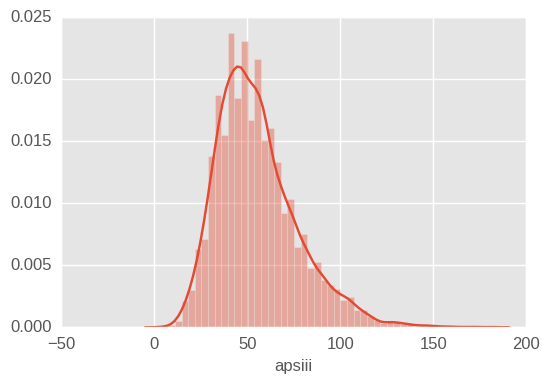

In [126]:
sns.distplot(to_plot.apsiii)

In [127]:
to_plot['apsiii_high'] = to_plot.apsiii > 70

In [129]:
table = to_plot.groupby(['day30_mortality', 'apsiii_high']).size().unstack()
table

apsiii_high,False,True
day30_mortality,,
False,13671,2161
True,3712,2479


In [131]:
table = to_plot.groupby(['day30_mortality', 'apsiii_high', 'filter_echo']).size()\
            .unstack().unstack()
table

filter_echo     False       True       
apsiii_high     False True  False True 
day30_mortality                        
False            7939   948  5732  1213
True             2009  1334  1703  1145

In [132]:
table = to_plot.groupby(['day30_mortality', 'apsiii_high', 'filter_echo']).size()\
            .unstack().unstack()
table /= table.sum(0)
table

filter_echo        False               True           
apsiii_high        False     True      False     True 
day30_mortality                                       
False            0.79805  0.415425  0.770948  0.514419
True             0.20195  0.584575  0.229052  0.485581

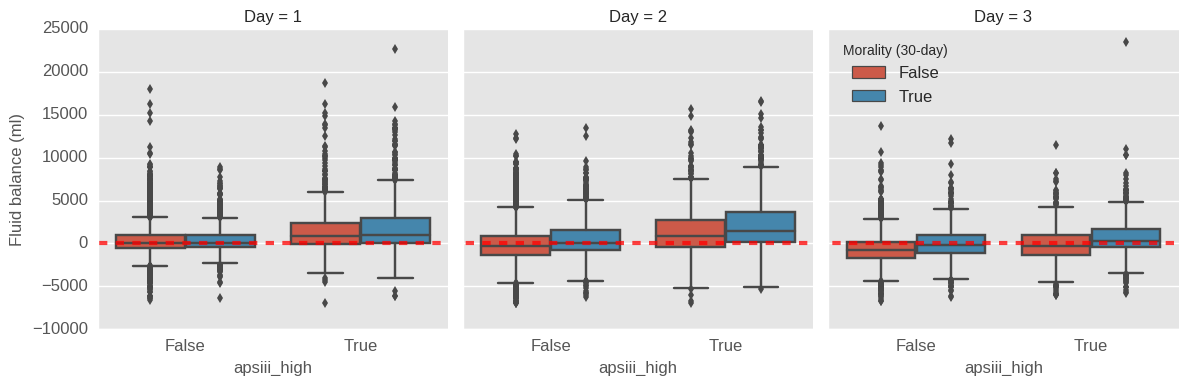

In [133]:
g  = sns.factorplot(data=to_plot, x='apsiii_high', y='Fluid balance (ml)', kind='box', legend=False
               #, hue='Day', col='ex_congestive_heart_failure')
               , hue='day30_mortality', col='Day')
for ax in g.axes.ravel():
    ax.plot([-100, 100], [0, 0], '--r', linewidth=3, alpha=0.75)
plt.legend(loc='best', title='Morality (30-day)')

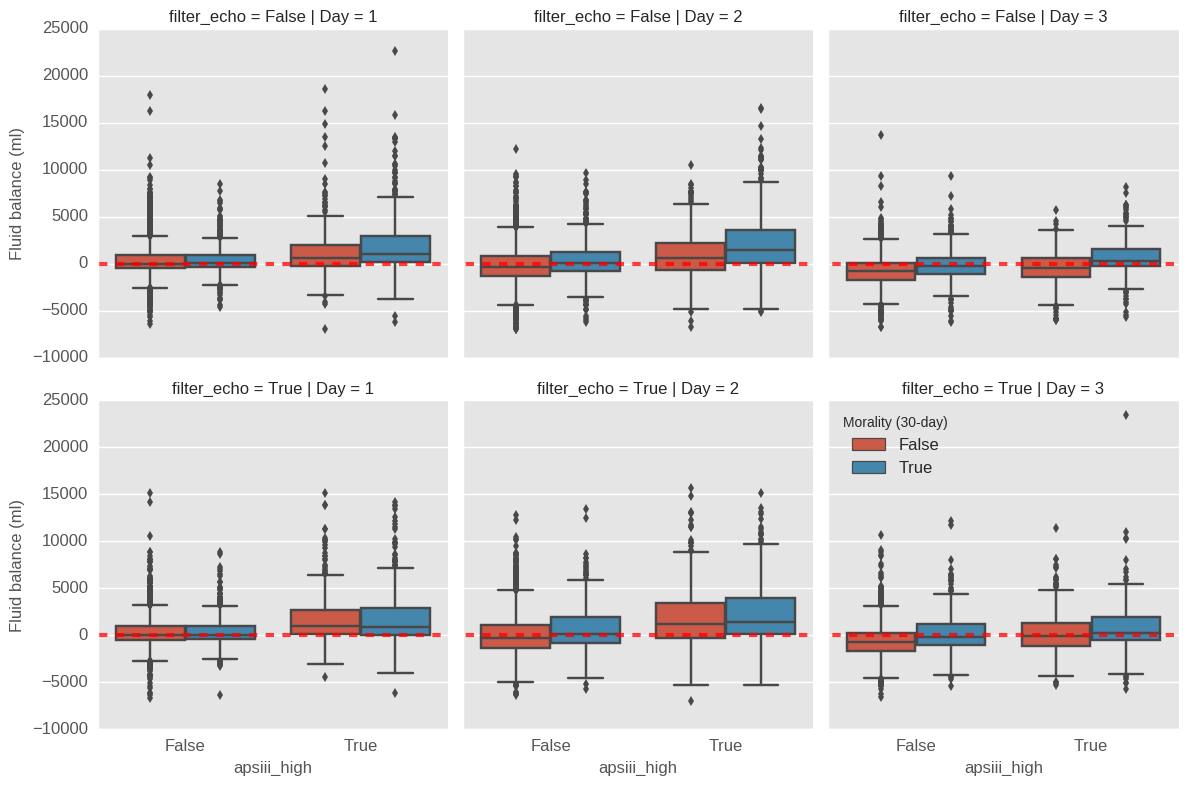

In [134]:
g  = sns.factorplot(data=to_plot, x='apsiii_high', y='Fluid balance (ml)', kind='box', legend=False
               #, hue='Day', col='ex_congestive_heart_failure')
               , hue='day30_mortality', col='Day', row='filter_echo')
for ax in g.axes.ravel():
    ax.plot([-100, 100], [0, 0], '--r', linewidth=3, alpha=0.75)
plt.legend(loc='best', title='Morality (30-day)')

In [135]:
table = to_plot.groupby(['day30_mortality', 'apsiii_high', 'ea_lv_systolic']).size()\
            .unstack().unstack()
table

ea_lv_systolic  -50.0       -2.0        -1.0         0.0         1.0         \
apsiii_high     False True  False True  False True  False True  False True    
day30_mortality                                                               
False              38     8  9055  1217   325    85  3407   608   351    94   
True                7    10  2405  1563   127   147   848   527   120    66   

ea_lv_systolic   2.0         3.0         
apsiii_high     False True  False True   
day30_mortality                          
False             204    50   291    99  
True               71    58   134   108

In [136]:
table = to_plot.groupby(['day30_mortality', 'apsiii_high', 'ea_lv_systolic']).size()\
            .unstack().unstack()
table /= table.sum(0)
table

ea_lv_systolic      -50.0              -2.0               -1.0             \
apsiii_high         False     True     False    True      False     True    
day30_mortality                                                             
False            0.844444  0.444444  0.79014  0.43777  0.719027  0.366379   
True             0.155556  0.555556  0.20986  0.56223  0.280973  0.633621   

ea_lv_systolic       0.0                 1.0               2.0             \
apsiii_high         False     True      False   True      False     True    
day30_mortality                                                             
False            0.800705  0.535683  0.745223  0.5875  0.741818  0.462963   
True             0.199295  0.464317  0.254777  0.4125  0.258182  0.537037   

ea_lv_systolic       3.0             
apsiii_high         False     True   
day30_mortality                      
False            0.684706  0.478261  
True             0.315294  0.521739

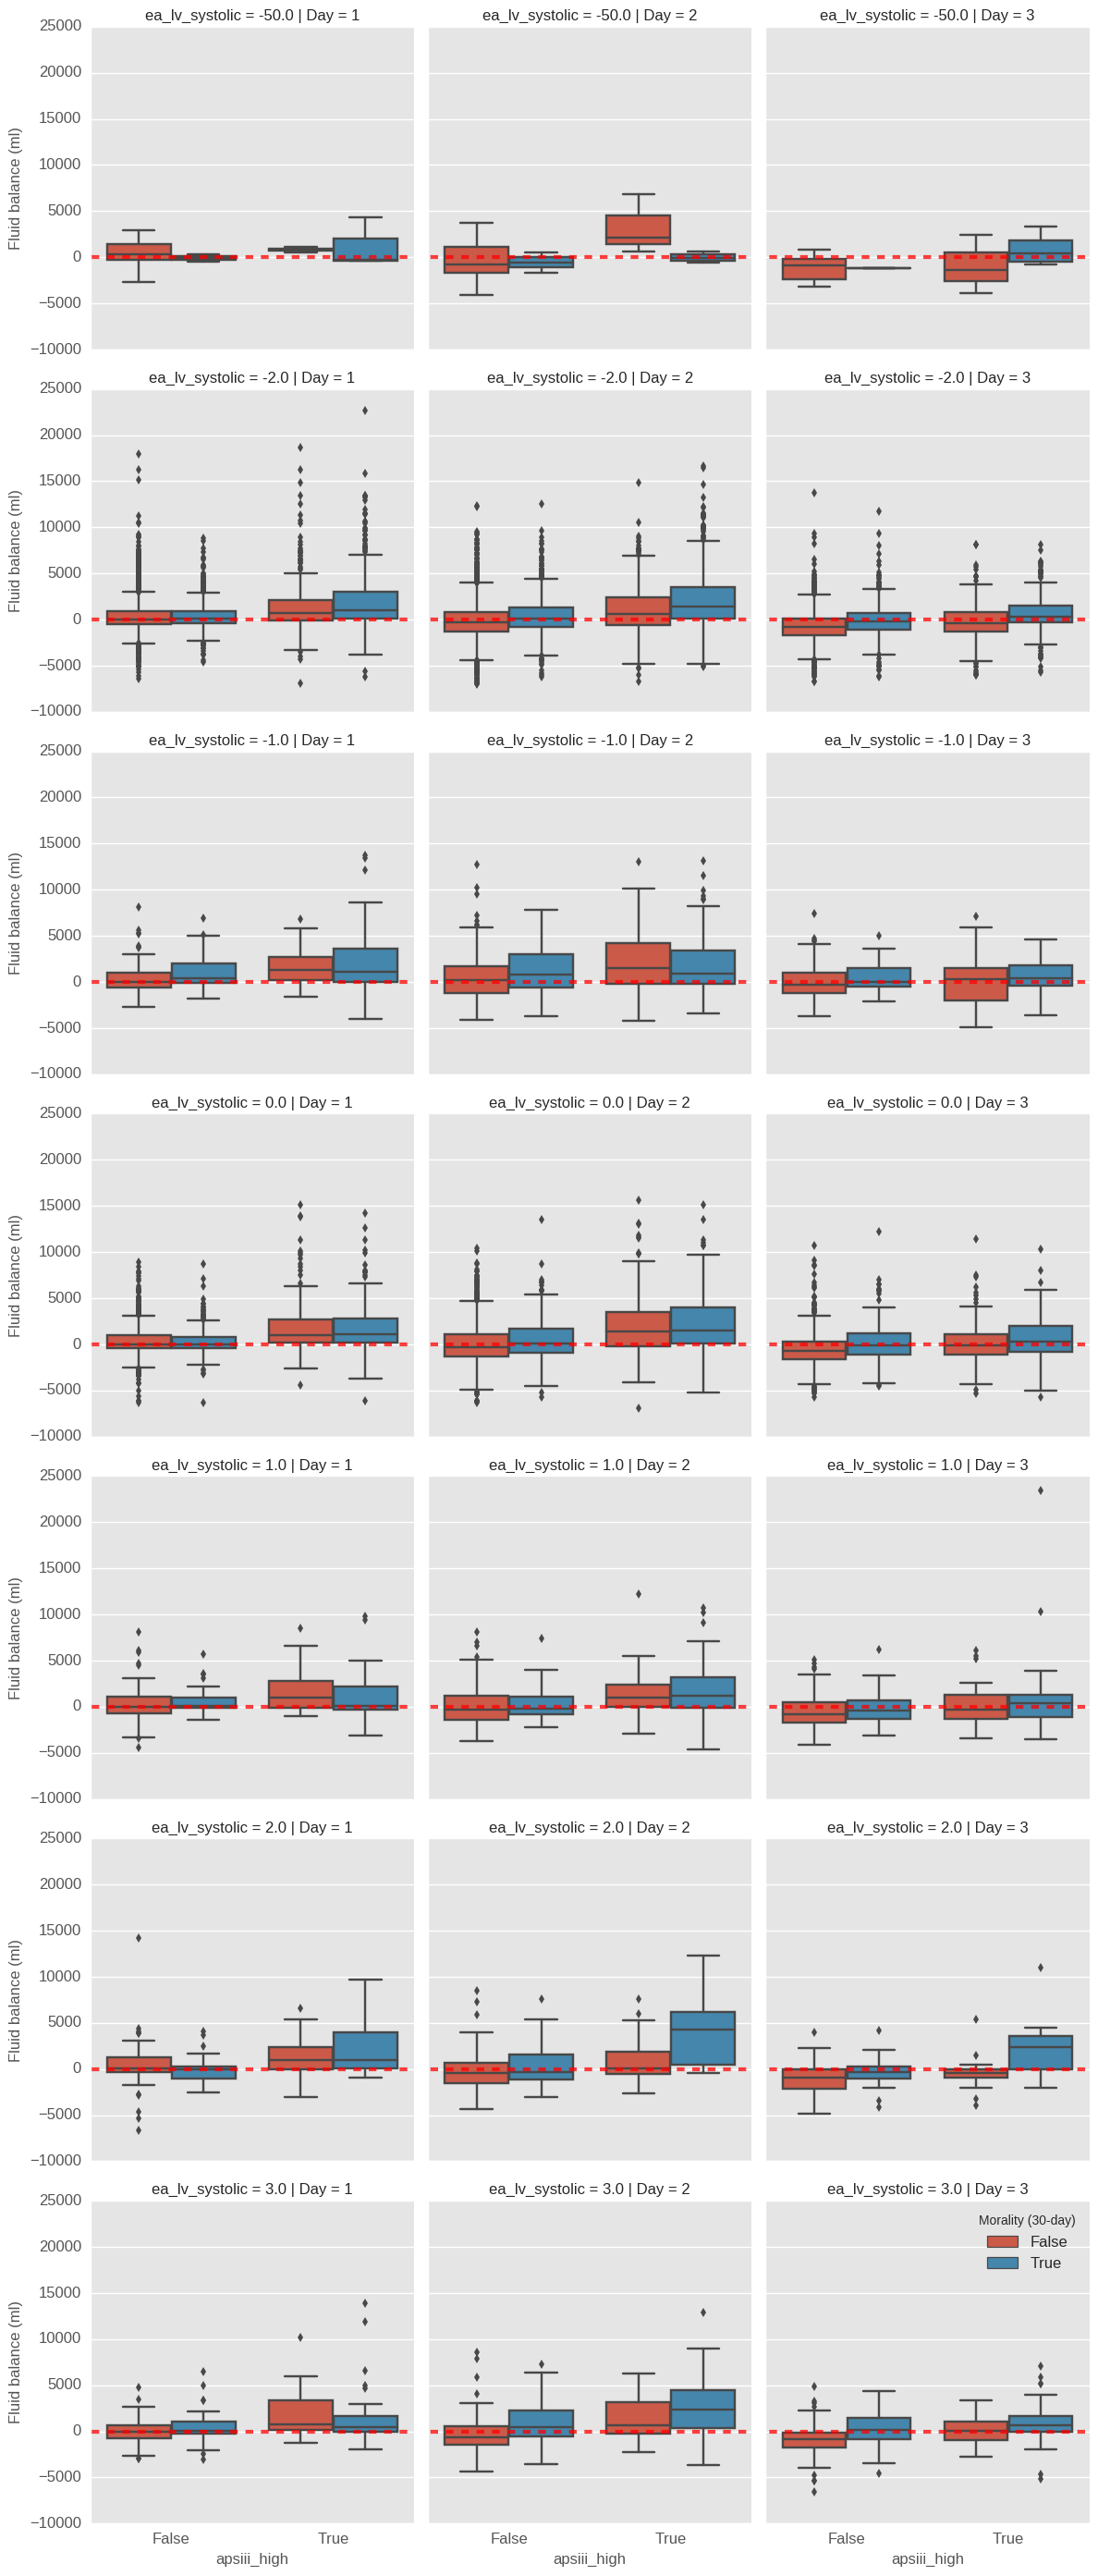

In [137]:
g  = sns.factorplot(data=to_plot, x='apsiii_high', y='Fluid balance (ml)', kind='box', legend=False
               #, hue='Day', col='ex_congestive_heart_failure')
               , hue='day30_mortality', col='Day', row='ea_lv_systolic')
for ax in g.axes.ravel():
    ax.plot([-100, 100], [0, 0], '--r', linewidth=3, alpha=0.75)
plt.legend(loc='best', title='Morality (30-day)')

## Congestive heart failure changes fluid management depending on LV systolic

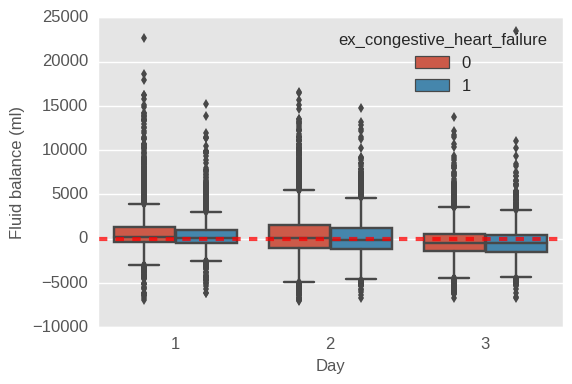

In [90]:
g = sns.boxplot(data=to_plot, x='Day', y='Fluid balance (ml)', hue='ex_congestive_heart_failure')
_ = plt.plot([-100, 100], [0, 0], '--r', linewidth=3, alpha=0.75)

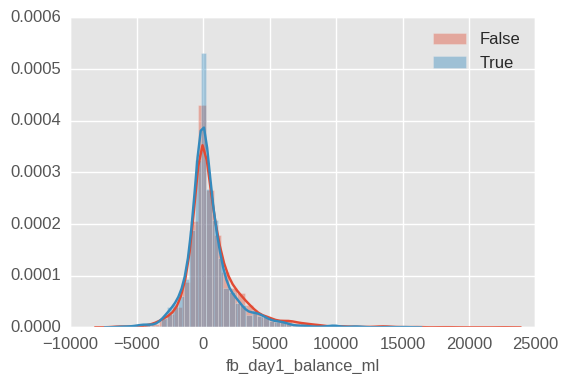

766.483371985 2252.14876878
442.46513909 1911.07172933
Ttest_indResult(statistic=6.1257287416948962, pvalue=9.7705879311594483e-10)
-0.0690082392054 9.5299585798e-09


In [91]:
filter = (ef.fb_day1_balance_ml >= -7000)
group_0 = ef.loc[filter & (ef.ex_congestive_heart_failure == False)].fb_day1_balance_ml
group_0 = group_0.dropna()
group_1 = ef.loc[filter & (ef.ex_congestive_heart_failure == True)].fb_day1_balance_ml
group_1 = group_1.dropna()

f = plt.figure()
sns.distplot(group_0, label='False')
sns.distplot(group_1, label='True')
plt.legend()
display(f)
plt.close()
print(group_0.mean(), group_0.std())
print(group_1.mean(), group_1.std())

stats = {}
ttest = ttest_ind(group_0, group_1, equal_var=False)
print(ttest)
stats['t-test p-value'] = ttest.pvalue
data = ef.loc[filter,['fb_day1_balance_ml', 'ex_congestive_heart_failure']].dropna()
r, pval = pearsonr(data.fb_day1_balance_ml, data.ex_congestive_heart_failure)
print(r, pval)

In [92]:
counts = ef.groupby('ex_congestive_heart_failure').apply(lambda x: x['ea_lv_systolic'].value_counts())
counts = counts.unstack().T
counts.index.name = 'ea_lv_systolic'
counts

ex_congestive_heart_failure,0,1
ea_lv_systolic,,
-50.0,14,11
-2.0,4641,1910
-1.0,190,79
0.0,1482,667
1.0,126,133
2.0,55,99
3.0,89,185


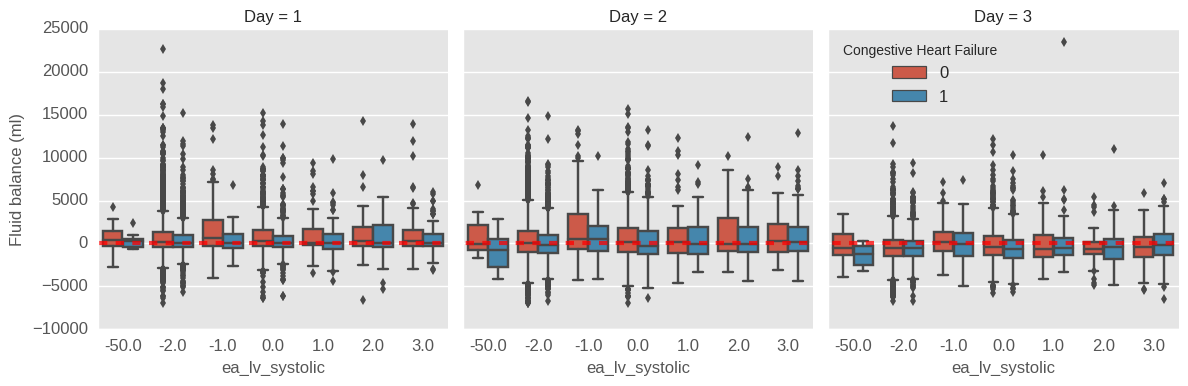

In [93]:
g  = sns.factorplot(data=to_plot, x='ea_lv_systolic', y='Fluid balance (ml)', kind='box', legend=False
               #, hue='Day', col='ex_congestive_heart_failure')
               , hue='ex_congestive_heart_failure', col='Day')
for ax in g.axes.ravel():
    ax.plot([-100, 100], [0, 0], '--r', linewidth=3, alpha=0.75)
plt.legend(loc='best', title='Congestive Heart Failure')

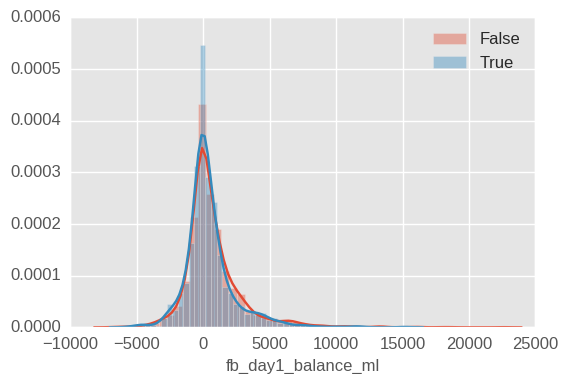

LV systolic: -2
696.453335471 2204.46873492
451.113369062 1901.5955104
Ttest_indResult(statistic=3.7268104795598163, pvalue=0.00019803723714926076)
-0.0514596121384 0.000491319846543



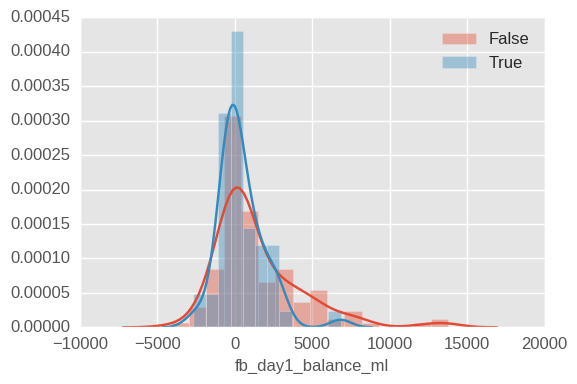

LV systolic: -1
1474.69466272 2865.27529329
436.649103398 1510.94041311
Ttest_indResult(statistic=3.312980113233726, pvalue=0.0011259117774354932)
-0.17497664735 0.0127492552411



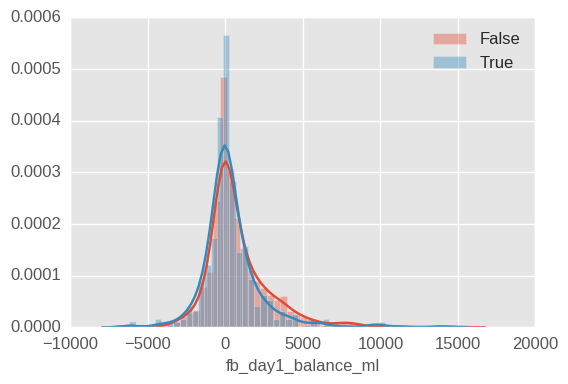

LV systolic: 0
821.274348918 2178.00599844
396.373636326 1986.67669701
Ttest_indResult(statistic=3.8008546695641163, pvalue=0.00015315678528512154)
-0.0911038793196 0.000258727340199



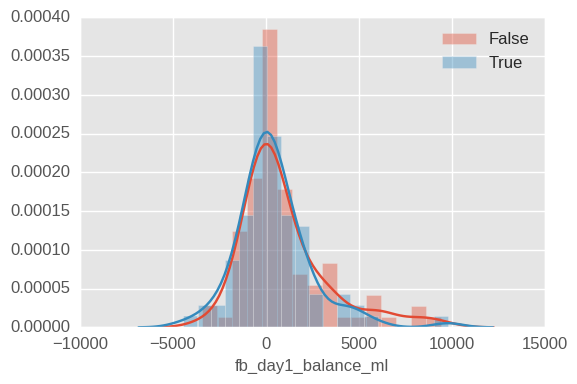

LV systolic: 1
978.395780351 2354.07566213
438.16023961 2008.59958811
Ttest_indResult(statistic=1.6691877514156044, pvalue=0.096857794016542681)
-0.123230622101 0.0965226507816



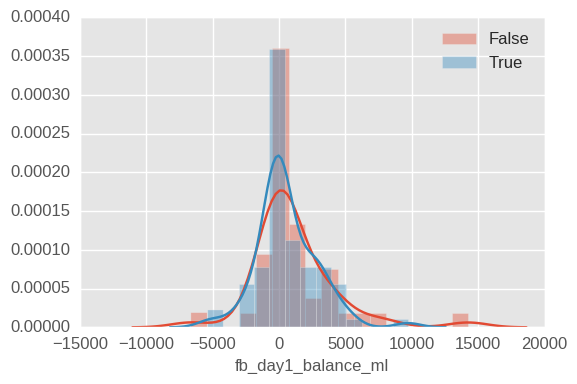

LV systolic: 2
1159.55479021 3148.72887002
601.290929468 2272.92399771
Ttest_indResult(statistic=1.0232391640996277, pvalue=0.309882294347609)
-0.102552909916 0.265024535557



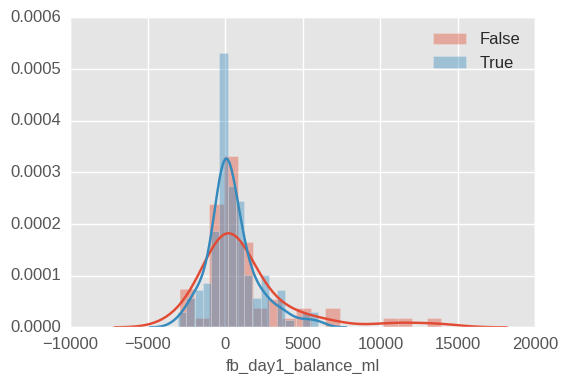

LV systolic: 3
1281.86282414 3203.00579976
444.97687085 1615.21536213
Ttest_indResult(statistic=1.8864915215522622, pvalue=0.063366959675289977)
-0.171967117991 0.0179752478118



,LV Systolic,Pearson r,t-test p-value
0,-2,-0.051460,0.000198
1,-1,-0.174977,0.001126
2,0,-0.091104,0.000153
3,1,-0.123231,0.096858
4,2,-0.102553,0.309882
5,3,-0.171967,0.063367


In [94]:
statistics = []
for systolic_flag in [-2,-1,0,1,2,3]:
    filter = (ef.ea_lv_systolic == systolic_flag) & (ef.fb_day1_balance_ml >= -7000)
    group_0 = ef.loc[filter & (ef.ex_congestive_heart_failure == False)].fb_day1_balance_ml
    group_0 = group_0.dropna()
    group_1 = ef.loc[filter & (ef.ex_congestive_heart_failure == True)].fb_day1_balance_ml
    group_1 = group_1.dropna()

    f = plt.figure()
    sns.distplot(group_0, label='False')
    sns.distplot(group_1, label='True')
    plt.legend()
    display(f)
    plt.close()
    print('LV systolic:', systolic_flag)
    print(group_0.mean(), group_0.std())
    print(group_1.mean(), group_1.std())

    stats = {}
    ttest = ttest_ind(group_0, group_1, equal_var=False)
    print(ttest)
    stats['t-test p-value'] = ttest.pvalue
    data = ef.loc[filter,['fb_day1_balance_ml', 'ex_congestive_heart_failure']].dropna()
    r, pval = pearsonr(data.fb_day1_balance_ml, data.ex_congestive_heart_failure)
    print(r, pval)
    stats['Pearson r'] = r
    stats['LV Systolic'] = systolic_flag
    statistics.append(stats)
    print('')
statistics = pd.DataFrame(statistics)
statistics

In [95]:
from scipy.stats import ttest_ind
filter = (ef.ea_lv_systolic == 3)
group_0 = ef.loc[filter & (ef.ex_congestive_heart_failure == 0)].fb_day1_balance_ml.dropna()
group_1 = ef.loc[filter & (ef.ex_congestive_heart_failure == 1)].fb_day1_balance_ml.dropna()
print(group_0.mean(), group_1.mean())
print(group_0.std(), group_1.std())
ttest_ind(group_0, group_1, equal_var=False)

1281.86282414 444.97687085
3203.00579976 1615.21536213


Ttest_indResult(statistic=1.8864915215522622, pvalue=0.063366959675289977)

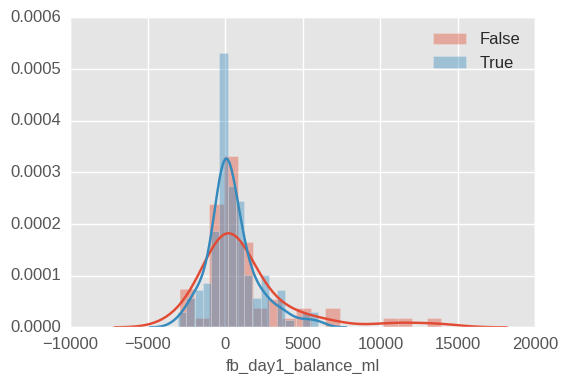

In [96]:
sns.distplot(group_0, label='False')
sns.distplot(group_1, label='True')
plt.legend()

### Break down by congestive heart failure

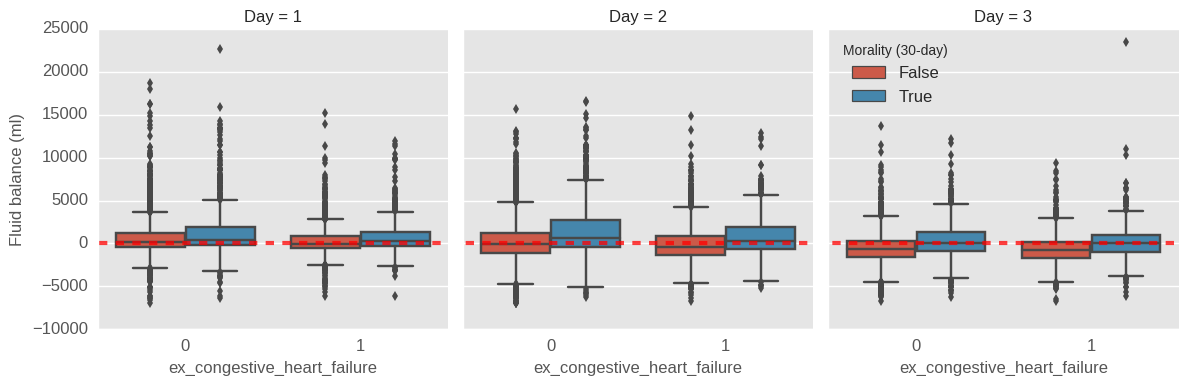

In [108]:
g  = sns.factorplot(data=to_plot, x='ex_congestive_heart_failure', y='Fluid balance (ml)', kind='box', legend=False
               #, hue='Day', col='ex_congestive_heart_failure')
               , hue='day30_mortality', col='Day')
for ax in g.axes.ravel():
    ax.plot([-100, 100], [0, 0], '--r', linewidth=3, alpha=0.75)
plt.legend(loc='best', title='Morality (30-day)')

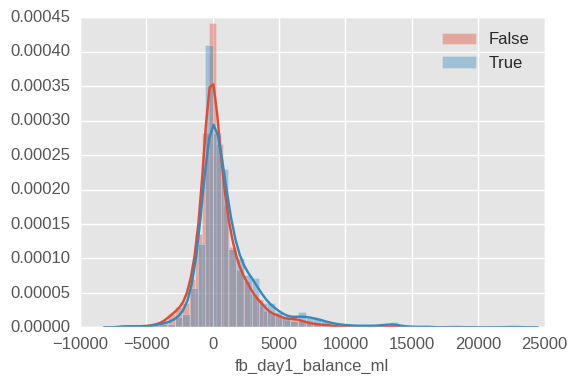

600.378908625 2090.0957419
1193.909058 2575.57965892
Ttest_indResult(statistic=-7.5413321558974884, pvalue=6.9230000171873479e-14)
0.118322972685 1.87890769074e-16


In [109]:
# is the difference significant for non CHF patients
filter = (ef.ex_congestive_heart_failure == 0) & (ef.fb_day1_balance_ml >= -7000)
group_0 = ef.loc[filter & (ef.day30_mortality == False)].fb_day1_balance_ml
group_0 = group_0.dropna()
group_1 = ef.loc[filter & (ef.day30_mortality == True)].fb_day1_balance_ml
group_1 = group_1.dropna()

f = plt.figure()
sns.distplot(group_0, label='False')
sns.distplot(group_1, label='True')
plt.legend()
display(f)
plt.close()
print(group_0.mean(), group_0.std())
print(group_1.mean(), group_1.std())

stats = {}
ttest = ttest_ind(group_0, group_1, equal_var=False)
print(ttest)
stats['t-test p-value'] = ttest.pvalue
data = ef.loc[filter,['fb_day1_balance_ml', 'day30_mortality']].dropna()
r, pval = pearsonr(data.fb_day1_balance_ml, data.day30_mortality)
print(r, pval)

In [110]:
counts = ef.groupby(['ex_congestive_heart_failure', 'ea_lv_systolic']).apply(lambda x: x['day30_mortality'].value_counts())
counts = counts.unstack().T
counts.index.name = 'day30_mortality'
counts

ex_congestive_heart_failure        0     1
day30_mortality ea_lv_systolic            
False           -50.0              9     8
                -2.0            3364  1314
                -1.0             110    48
                 0.0            1115   494
                 1.0              84   100
                 2.0              39    61
                 3.0              49   116
True            -50.0              5     3
                -2.0            1277   596
                -1.0              80    31
                 0.0             367   173
                 1.0              42    33
                 2.0              16    38
                 3.0              40    69

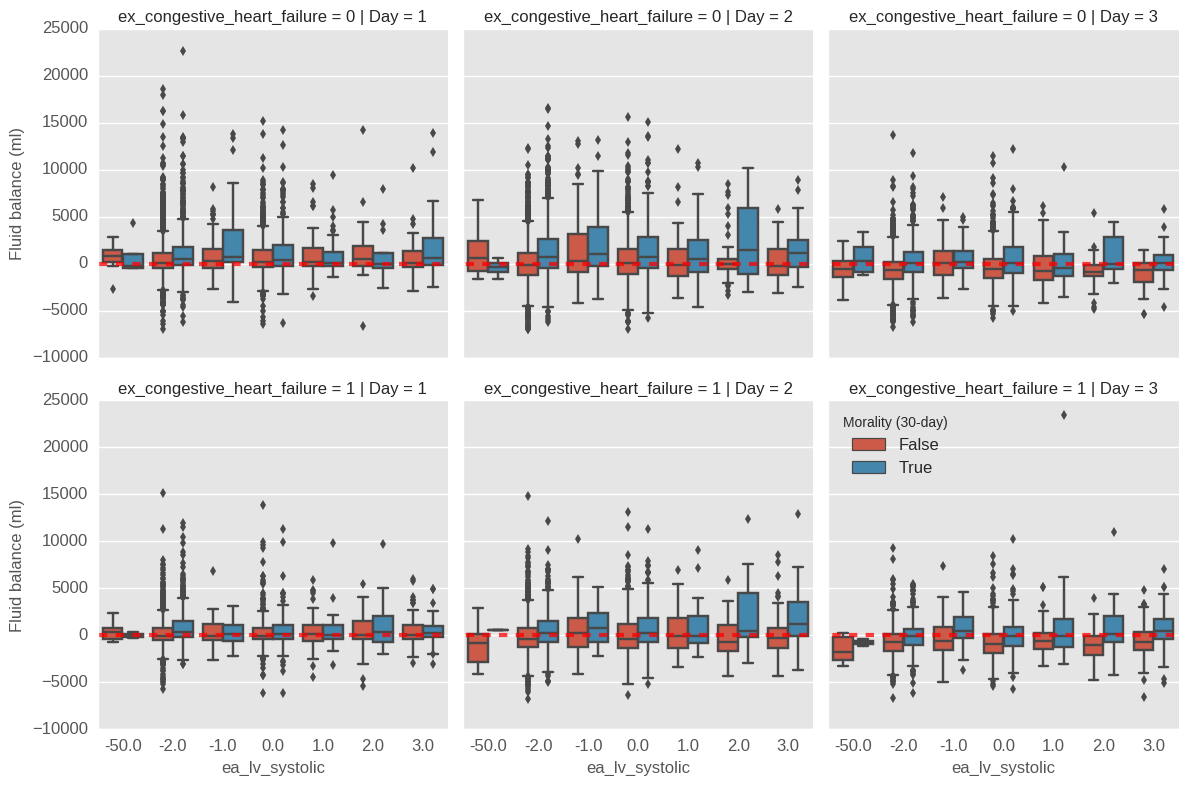

In [111]:
g  = sns.factorplot(data=to_plot, x='ea_lv_systolic', y='Fluid balance (ml)', kind='box', legend=False
               #, hue='Day', col='ex_congestive_heart_failure')
               , hue='day30_mortality', col='Day', row='ex_congestive_heart_failure')
for ax in g.axes.ravel():
    ax.plot([-100, 100], [0, 0], '--r', linewidth=3, alpha=0.75)
plt.legend(loc='best', title='Morality (30-day)')

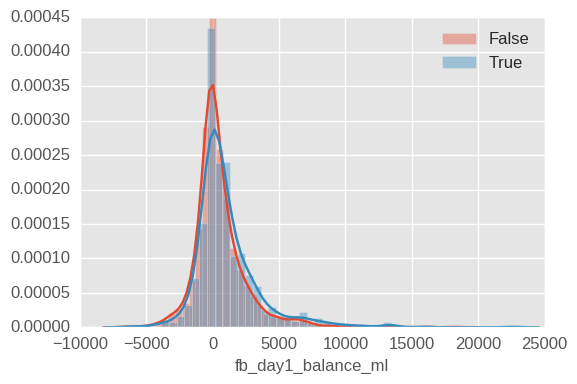

LV systolic: -2
541.298125306 2058.63612885
1103.27097258 2503.4598345
Ttest_indResult(statistic=-6.0642023756951211, pvalue=1.698563629028392e-09)
0.113984143956 4.34913358416e-11



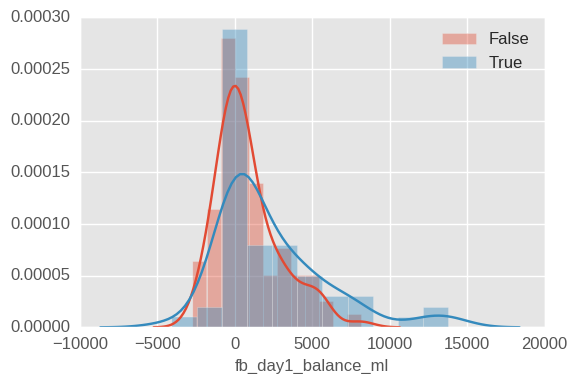

LV systolic: -1
838.764110774 2066.3670702
2367.04882432 3537.3600611
Ttest_indResult(statistic=-3.0510810290207799, pvalue=0.0029920912026133134)
0.263796721243 0.0011511756443



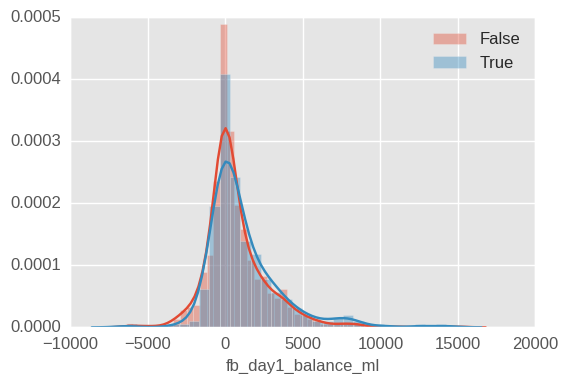

LV systolic: 0
697.251861071 2092.28061651
1176.35243056 2374.809776
Ttest_indResult(statistic=-3.0577100779824566, pvalue=0.0023608056986762784)
0.0963930389139 0.00118948384378



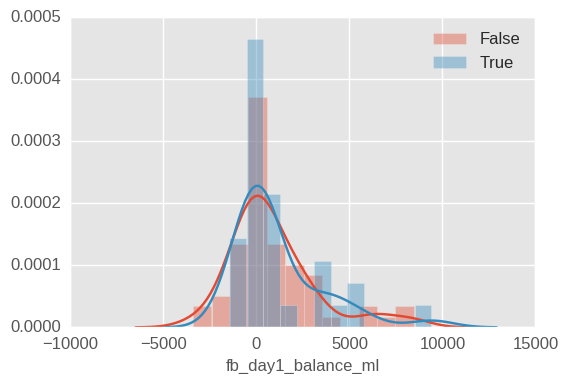

LV systolic: 1
896.478570348 2367.70556439
1136.94521907 2358.05604907
Ttest_indResult(statistic=-0.46039509842927173, pvalue=0.64687021684021495)
0.0486798189941 0.64678847976



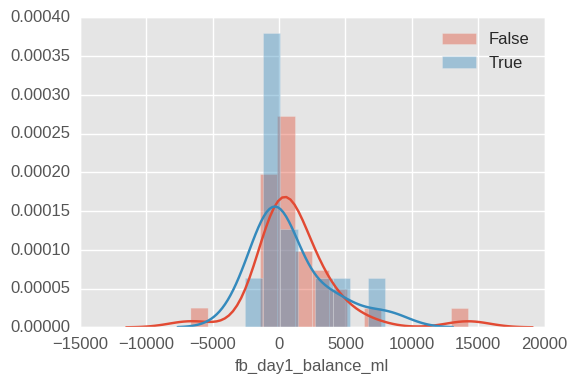

LV systolic: 2
1243.55734181 3277.5240157
942.548198597 2913.2918751
Ttest_indResult(statistic=0.29322557956355333, pvalue=0.77204388668933477)
-0.0433867399135 0.782354225994



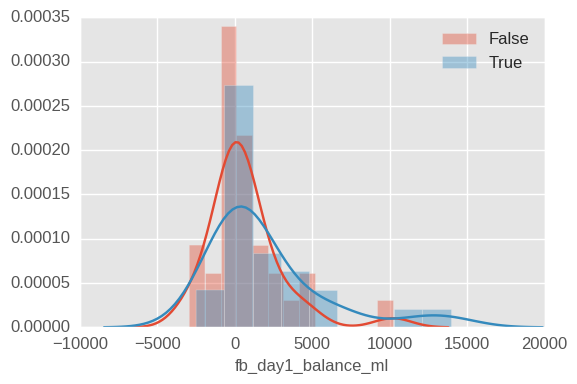

LV systolic: 3
669.878040537 2429.62383266
2035.07486551 3873.22320478
Ttest_indResult(statistic=-1.564480459948804, pvalue=0.12553885888568972)
0.213819733072 0.107037249268



,LV systolic,Pearson r,t-test p-value
0,-2,0.113984,1.698564e-09
1,-1,0.263797,2.992091e-03
2,0,0.096393,2.360806e-03
3,1,0.048680,6.468702e-01
4,2,-0.043387,7.720439e-01
5,3,0.213820,1.255389e-01


In [112]:
statistics = []
for systolic_flag in [-2, -1, 0, 1, 2, 3]:
    filter = (ef.ex_congestive_heart_failure == 0) & (ef.ea_lv_systolic == systolic_flag)
    filter &= (ef.fb_day1_balance_ml >= -7000)
    group_0 = ef.loc[filter & (ef.day30_mortality == False)].fb_day1_balance_ml
    group_0 = group_0.dropna()
    group_1 = ef.loc[filter & (ef.day30_mortality == True)].fb_day1_balance_ml
    group_1 = group_1.dropna()

    f = plt.figure()
    sns.distplot(group_0, label='False')
    sns.distplot(group_1, label='True')
    plt.legend()
    display(f)
    plt.close()
    print('LV systolic:', systolic_flag)
    print(group_0.mean(), group_0.std())
    print(group_1.mean(), group_1.std())

    stats = {}
    ttest = ttest_ind(group_0, group_1, equal_var=False)
    print(ttest)
    stats['t-test p-value'] = ttest.pvalue
    data = ef.loc[filter,['fb_day1_balance_ml', 'day30_mortality']].dropna()
    r, pval = pearsonr(data.fb_day1_balance_ml, data.day30_mortality)
    print(r, pval)
    stats['Pearson r'] = r
    stats['LV systolic'] = systolic_flag
    statistics.append(stats)
    print('')
statistics = pd.DataFrame(statistics)
statistics

### Calculate MDRD and breakdown fluid management

In [113]:
def mdrd(data):
    creat = data.lab_creatinine
    age = data.age/np.timedelta64('1', 'Y')
    age.loc[age<0] = age.max()
    gender = data.gender.apply(lambda x: 0.742 if x == 'F' else 1)
    ethnicity = data.ethnicity.apply(lambda x: 1.212 if 'AFRICAN AMERICAN' in x else 1)
    return 175*creat**(-1.154) * age**(-0.203) * gender * ethnicity

In [114]:
value = mdrd(ef)
ef['mdrd'] = value
discrete = pd.cut(value, [0, 15, 30, 44, 60, 90, 1000000], labels=[5, 4, 3, 2, 1, 0], include_lowest=True)
ef['mdrd_discrete'] = discrete
discrete.value_counts()

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


0    2351
1    2038
2    1588
4    1534
3    1515
5     581
dtype: int64

In [115]:
to_plot = pd.merge(to_plot, ef[['mdrd_discrete']], left_on='row_id', right_index=True)

In [116]:
counts = ef.groupby('day30_mortality').apply(lambda x: x['mdrd_discrete'].value_counts())
counts = counts.unstack()
display(counts)
counts /= counts.sum(axis=0)
counts

,5,4,3,2,1,0
day30_mortality,,,,,,
False,356,939,1020,1140,1578,1818
True,225,595,495,448,460,533


,5,4,3,2,1,0
day30_mortality,,,,,,
False,0.612737,0.612125,0.673267,0.717884,0.774289,0.773288
True,0.387263,0.387875,0.326733,0.282116,0.225711,0.226712


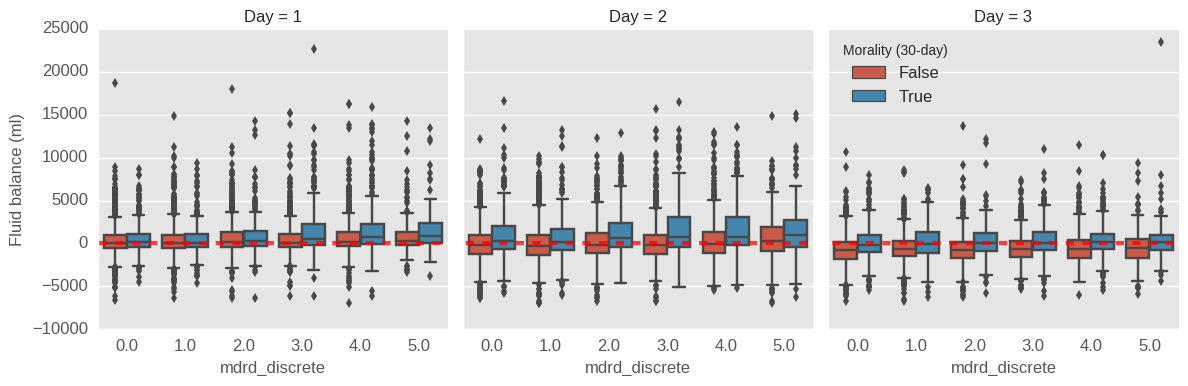

In [117]:
g  = sns.factorplot(data=to_plot, x='mdrd_discrete', y='Fluid balance (ml)', kind='box', legend=False
               #, hue='Day', col='ex_congestive_heart_failure')
               , hue='day30_mortality', col='Day')
for ax in g.axes.ravel():
    ax.plot([-100, 100], [0, 0], '--r', linewidth=3, alpha=0.75)
plt.legend(loc='best', title='Morality (30-day)')

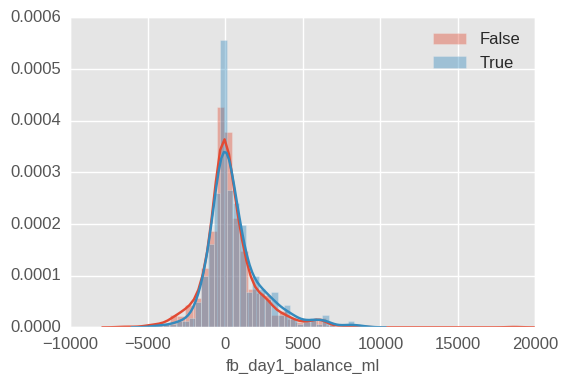

MDRD: 0
320.594762817 1854.54125465
607.111057368 1793.00293464
Ttest_indResult(statistic=-2.7674581309717823, pvalue=0.0058080713600995072)
0.0650686341896 0.00665581008609



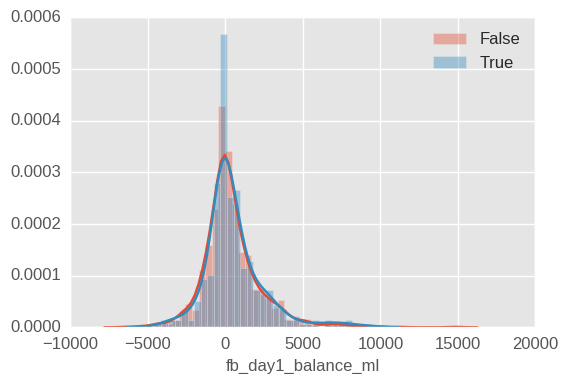

MDRD: 1
397.611885327 1926.93220087
542.453335112 1909.43868774
Ttest_indResult(statistic=-1.210296203859075, pvalue=0.22669996065089776)
0.0313603831536 0.228708131737



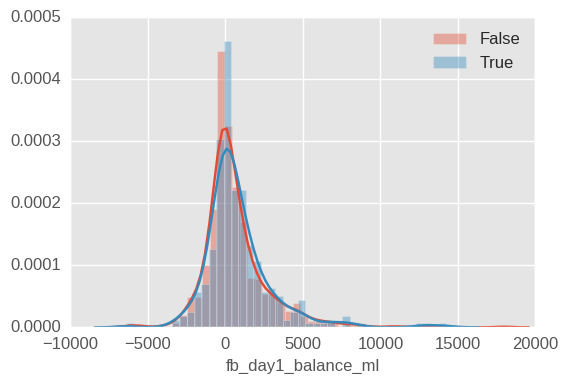

MDRD: 2
639.881858608 2077.00739894
836.256412795 2218.07738272
Ttest_indResult(statistic=-1.3793119377845602, pvalue=0.16832851938188553)
0.042180843758 0.156669591223



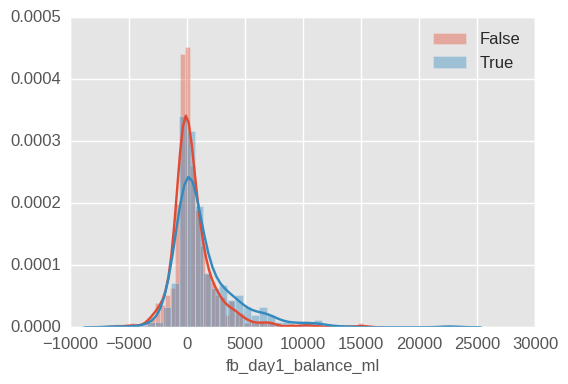

MDRD: 3
596.977416863 2107.25896315
1471.77162973 2858.65303149
Ttest_indResult(statistic=-5.1795735851295293, pvalue=3.0975819203968121e-07)
0.170538933767 1.35906434335e-08



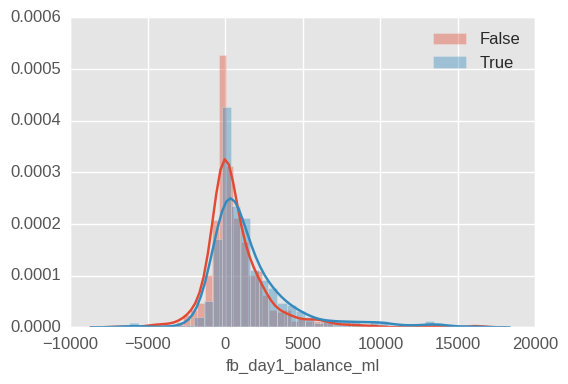

MDRD: 4
710.124441947 2197.40281333
1583.97278226 2802.61274565
Ttest_indResult(statistic=-5.4151877826888999, pvalue=8.271950810676631e-08)
0.171525877383 1.51990716193e-08



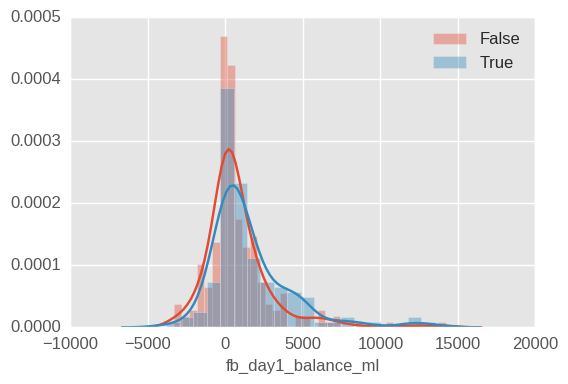

MDRD: 5
828.489648391 2267.50612862
1579.88431143 2617.25789273
Ttest_indResult(statistic=-2.8273876381435312, pvalue=0.0050392662117595679)
0.150869002853 0.00376780810624



,LV systolic,Pearson r,t-test p-value
0,3,0.065069,5.808071e-03
1,3,0.031360,2.267000e-01
2,3,0.042181,1.683285e-01
3,3,0.170539,3.097582e-07
4,3,0.171526,8.271951e-08
5,3,0.150869,5.039266e-03


In [118]:
statistics = []
for flag in range(6):
    filter = (ef.mdrd_discrete == flag)
    filter &= (ef.fb_day1_balance_ml >= -7000)
    group_0 = ef.loc[filter & (ef.day30_mortality == False)].fb_day1_balance_ml
    group_0 = group_0.dropna()
    group_1 = ef.loc[filter & (ef.day30_mortality == True)].fb_day1_balance_ml
    group_1 = group_1.dropna()

    f = plt.figure()
    sns.distplot(group_0, label='False')
    sns.distplot(group_1, label='True')
    plt.legend()
    display(f)
    plt.close()
    print('MDRD:', flag)
    print(group_0.mean(), group_0.std())
    print(group_1.mean(), group_1.std())

    stats = {}
    ttest = ttest_ind(group_0, group_1, equal_var=False)
    print(ttest)
    stats['t-test p-value'] = ttest.pvalue
    data = ef.loc[filter,['fb_day1_balance_ml', 'day30_mortality']].dropna()
    r, pval = pearsonr(data.fb_day1_balance_ml, data.day30_mortality)
    print(r, pval)
    stats['Pearson r'] = r
    stats['LV systolic'] = systolic_flag
    statistics.append(stats)
    print('')
statistics = pd.DataFrame(statistics)
statistics

In [119]:
counts = ef.groupby('mdrd_discrete').apply(lambda x: x['ea_lv_systolic'].value_counts())
counts = counts.unstack().fillna(0)
#counts.columns.name = 'day30_mortality'
counts

,-50.0,-2.0,-1.0,0.0,1.0,2.0,3.0
mdrd_discrete,,,,,,,
5,1,350,23,157,18,13,19
4,5,1017,47,328,51,28,58
3,6,1021,45,311,47,36,49
2,5,1057,38,349,48,26,65
1,5,1401,54,443,52,26,57
0,3,1643,60,554,42,24,25


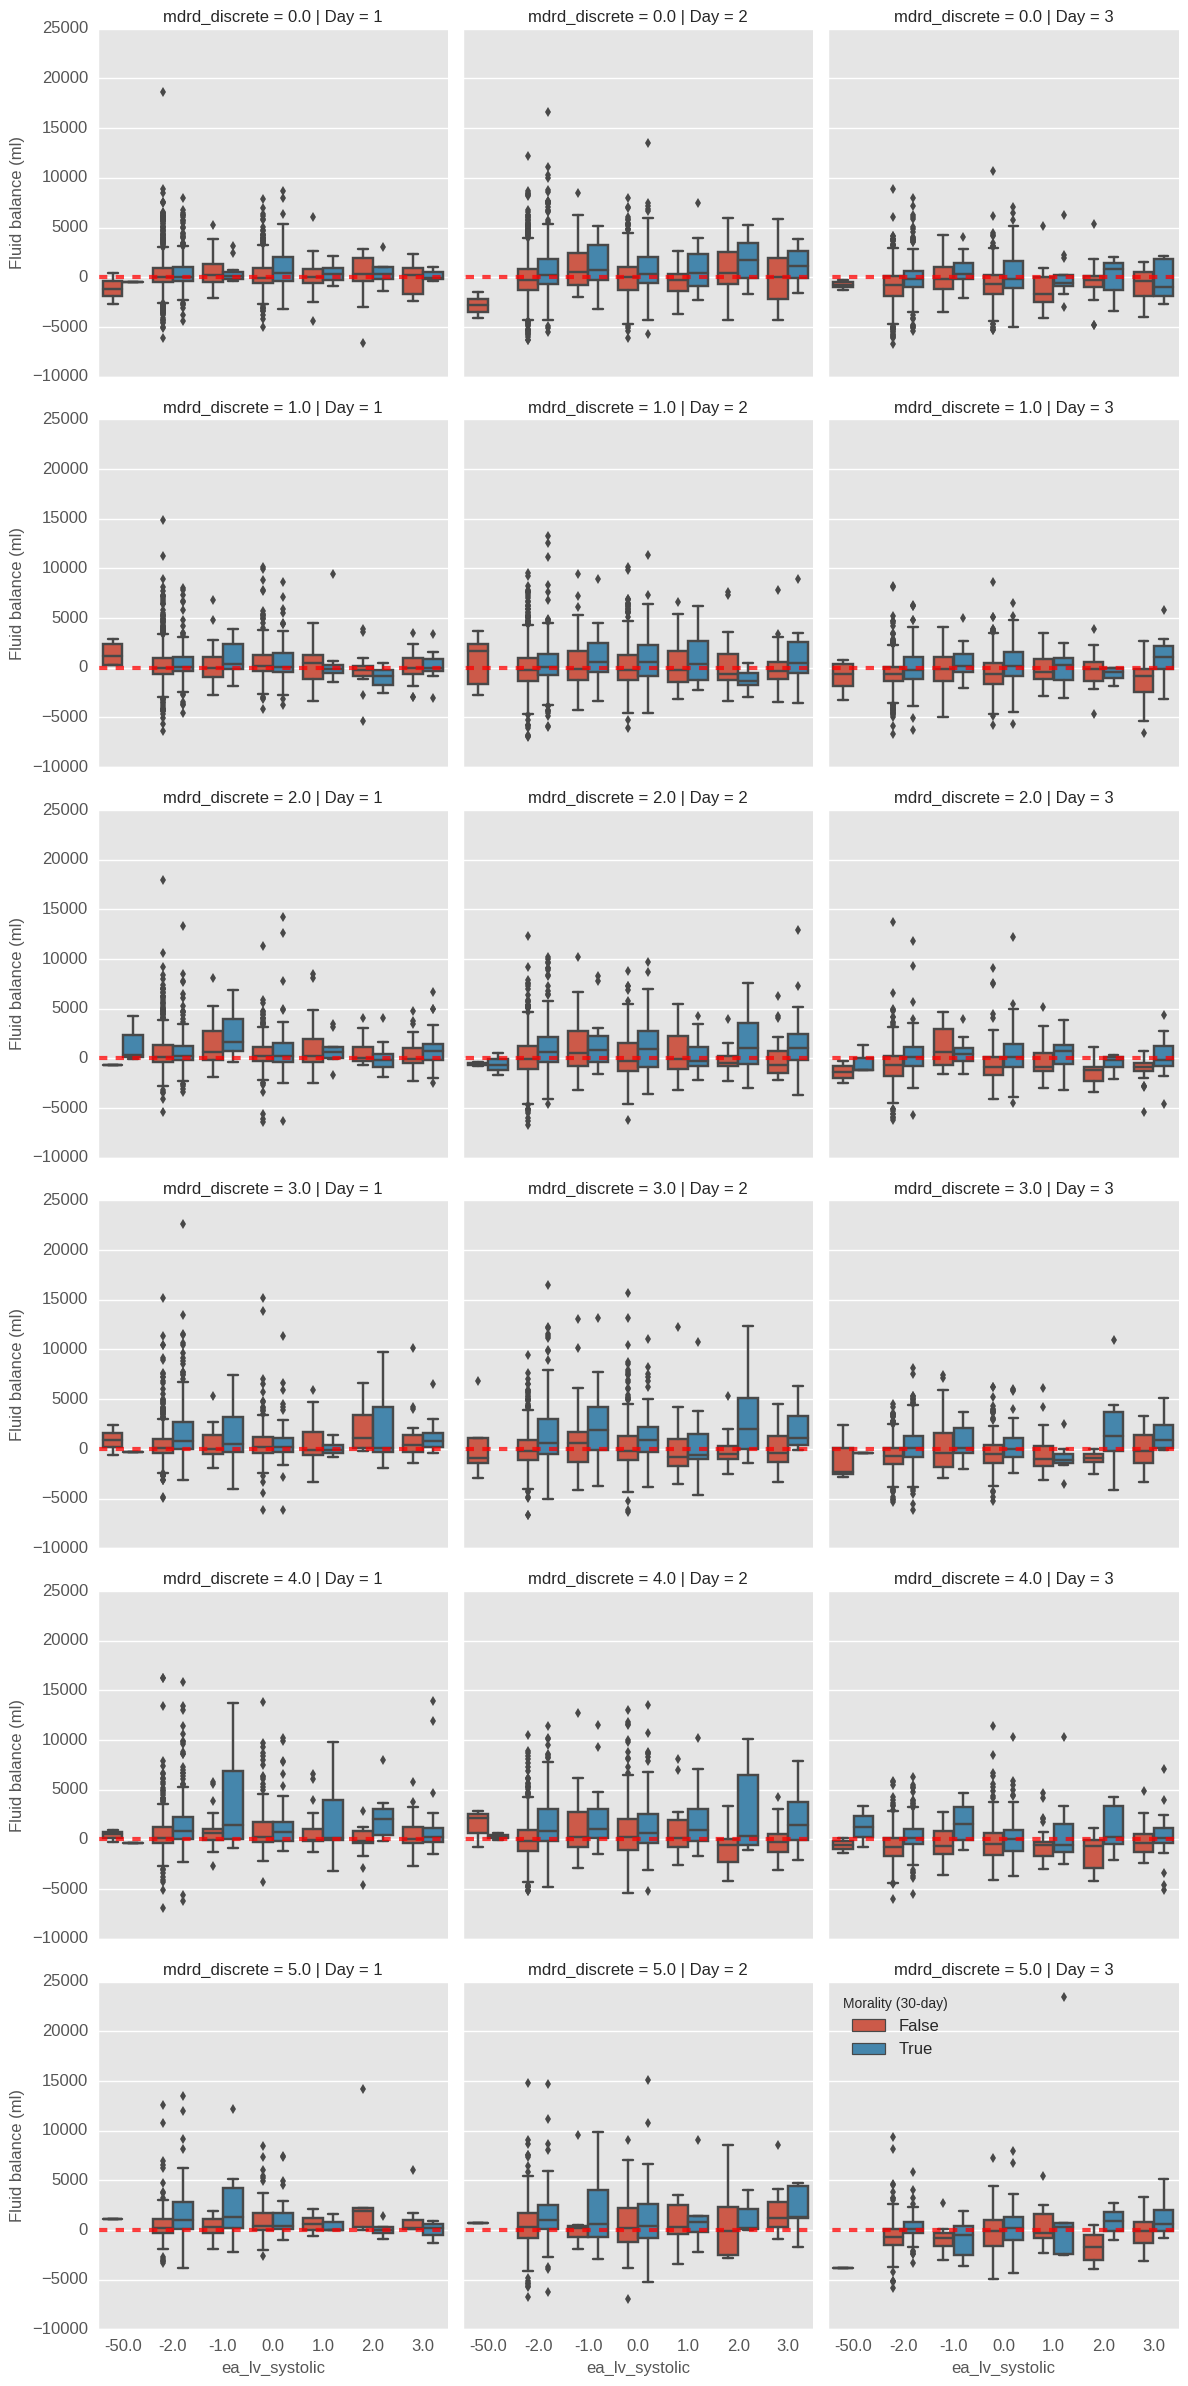

In [120]:
g  = sns.factorplot(data=to_plot, x='ea_lv_systolic', y='Fluid balance (ml)', kind='box', legend=False
               #, hue='Day', col='ex_congestive_heart_failure')
               , hue='day30_mortality', col='Day', row='mdrd_discrete')
for ax in g.axes.ravel():
    ax.plot([-100, 100], [0, 0], '--r', linewidth=3, alpha=0.75)
plt.legend(loc='best', title='Morality (30-day)')

In [121]:
filter = (ef.mdrd_discrete == 1) & (ef.ea_lv_systolic == 3) & (ef.fb_day1_balance_ml >= -7000)
group_0 = ef.loc[filter & (ef.day30_mortality == False)].fb_day1_balance_ml
group_0 = group_0.dropna()
group_1 = ef.loc[filter & (ef.day30_mortality == True)].fb_day1_balance_ml
group_1 = group_1.dropna()

131.554407349 1414.80643125
158.821971153 1537.73142936


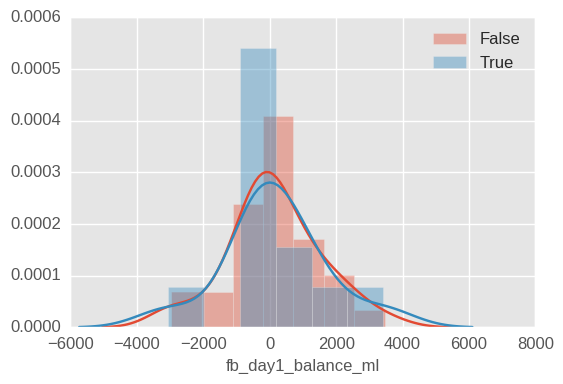

In [122]:
sns.distplot(group_0, label='False')
sns.distplot(group_1, label='True')
plt.legend()
print(group_0.mean(), group_0.std())
print(group_1.mean(), group_1.std())

In [123]:
ttest_ind(group_0, group_1, equal_var=False)

Ttest_indResult(statistic=-0.053516872294606575, pvalue=0.95789583943359835)

In [124]:
data = ef.loc[filter,['fb_day1_balance_ml', 'day30_mortality']].dropna()
pearsonr(data.fb_day1_balance_ml, data.day30_mortality)

(0.0085836774018314931, 0.95589986032374996)

### Break down by mechanical ventilation

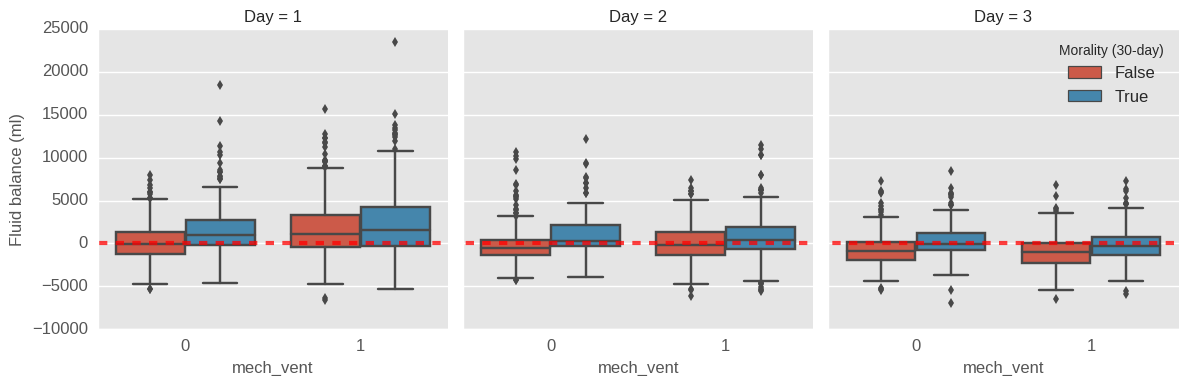

In [51]:
g  = sns.factorplot(data=to_plot, x='mech_vent', y='Fluid balance (ml)', kind='box', legend=False
               #, hue='Day', col='ex_congestive_heart_failure')
               , hue='day30_mortality', col='Day')
for ax in g.axes.ravel():
    ax.plot([-100, 100], [0, 0], '--r', linewidth=3, alpha=0.75)
plt.legend(loc='best', title='Morality (30-day)')

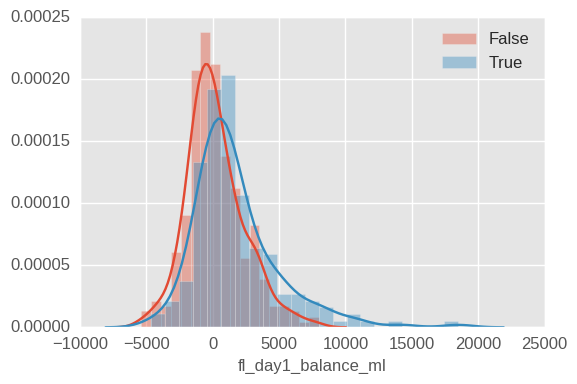

mech_vent = 0
219.159318894 2181.59812261
1732.23966104 3229.71167788
Ttest_indResult(statistic=-5.5676240404138229, pvalue=6.2163276112223058e-08)
0.268998538173 1.43754084128e-09



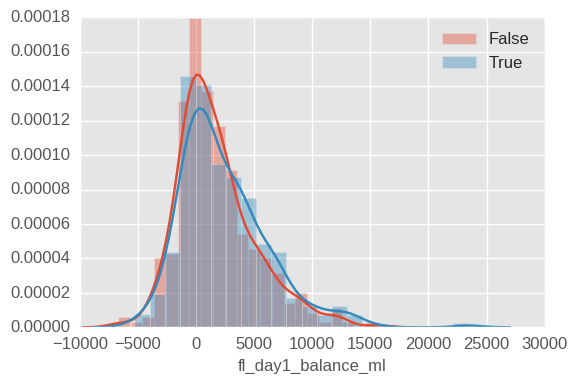

mech_vent = 1
1761.28181638 3348.22411482
2444.83997565 3810.58129388
Ttest_indResult(statistic=-2.4420324966026774, pvalue=0.014878791080679687)
0.0951785175588 0.0142928443322



In [52]:
for flag in [0,1]:
    filter = (ef.mech_vent == flag) & (ef.fb_day1_balance_ml >= -7000)
    group_0 = ef.loc[filter & (ef.day30_mortality == False)].fb_day1_balance_ml
    group_0 = group_0.dropna()
    group_1 = ef.loc[filter & (ef.day30_mortality == True)].fb_day1_balance_ml
    group_1 = group_1.dropna()

    f = plt.figure()
    sns.distplot(group_0, label='False')
    sns.distplot(group_1, label='True')
    plt.legend()
    display(f)
    plt.close()
    print('mech_vent =', flag)
    print(group_0.mean(), group_0.std())
    print(group_1.mean(), group_1.std())

    stats = {}
    ttest = ttest_ind(group_0, group_1, equal_var=False)
    print(ttest)
    stats['t-test p-value'] = ttest.pvalue
    data = ef.loc[filter,['fb_day1_balance_ml', 'day30_mortality']].dropna()
    r, pval = pearsonr(data.fb_day1_balance_ml, data.day30_mortality)
    print(r, pval)
    print('')

In [53]:
counts = ef.groupby(['mech_vent', 'ea_lv_systolic']).apply(lambda x: x['day30_mortality'].value_counts())
counts = counts.unstack().T
counts.index.name = 'day30_mortality'
counts

mech_vent           0                                    1                     \
ea_lv_systolic  -50.0 -1.0    0.0   1.0   2.0   3.0  -50.0 -1.0    0.0   1.0    
day30_mortality                                                                 
False             2.0  18.0  202.0  26.0  15.0  24.0   2.0  34.0  176.0  30.0   
True              NaN  32.0   98.0  13.0   9.0  27.0   1.0  30.0  145.0  22.0   

mech_vent                    
ea_lv_systolic   2.0   3.0   
day30_mortality              
False            17.0  34.0  
True             21.0  55.0

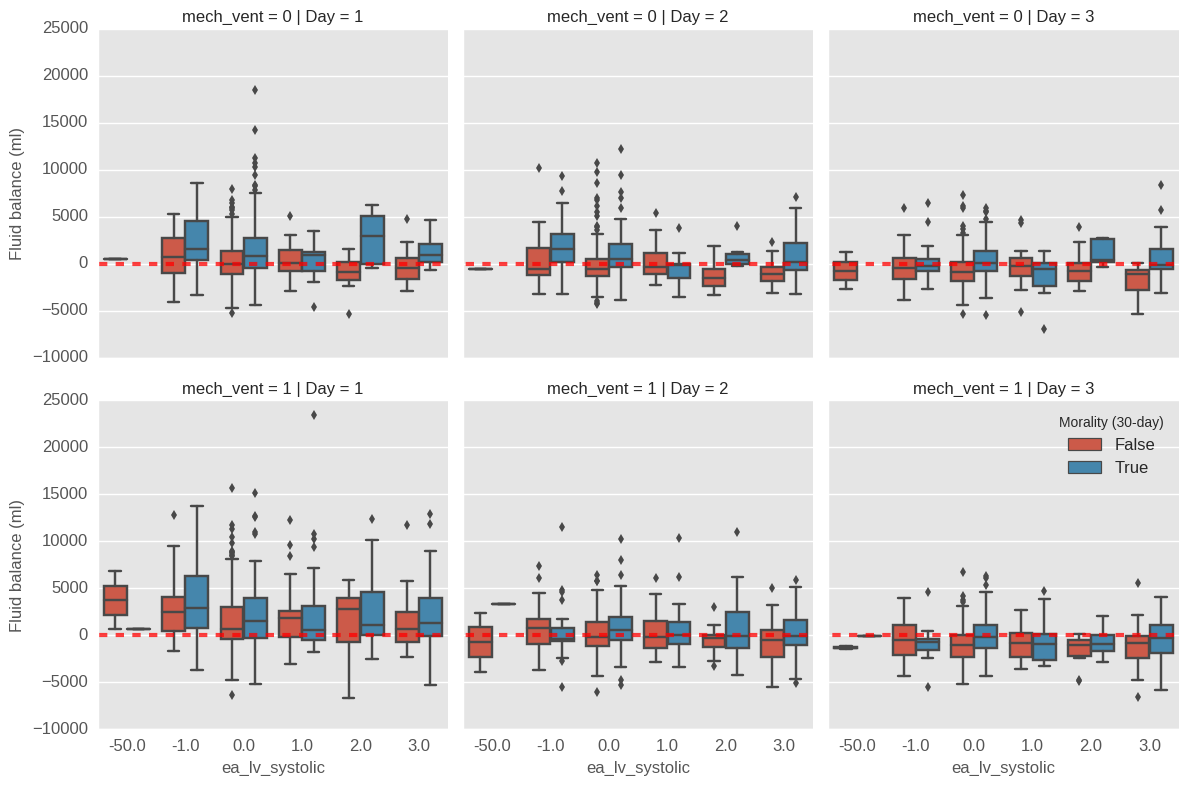

In [54]:
g  = sns.factorplot(data=to_plot, x='ea_lv_systolic', y='Fluid balance (ml)', kind='box', legend=False
               #, hue='Day', col='ex_congestive_heart_failure')
               , hue='day30_mortality', col='Day', row='mech_vent')
for ax in g.axes.ravel():
    ax.plot([-100, 100], [0, 0], '--r', linewidth=3, alpha=0.75)
plt.legend(loc='best', title='Morality (30-day)')

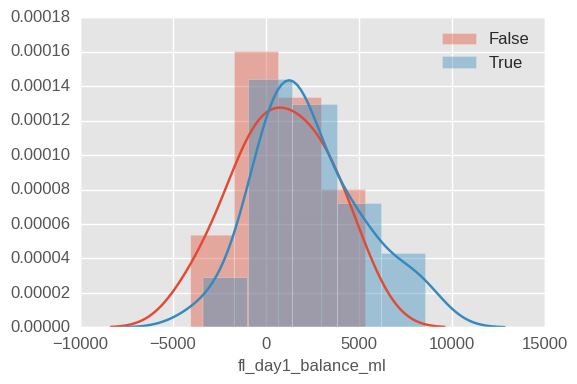

LV systolic: -1
875.859141852 2572.88010486
2324.26350556 2825.02479943
Ttest_indResult(statistic=-1.7450264906360828, pvalue=0.09011540491642836)
0.250621439334 0.0968079332066



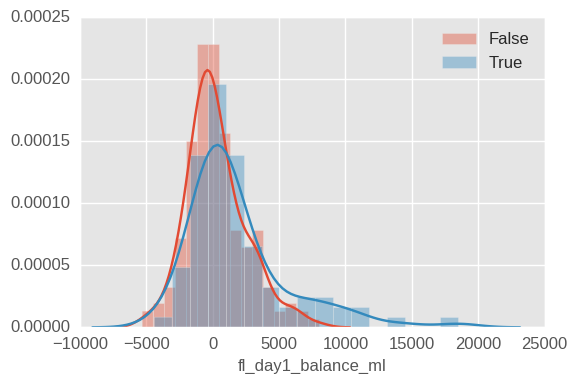

LV systolic: 0
288.119645955 2245.75519703
1855.44484276 3846.67116102
Ttest_indResult(statistic=-3.5969708173571862, pvalue=0.00046722719712399423)
0.24936961735 2.78431785229e-05



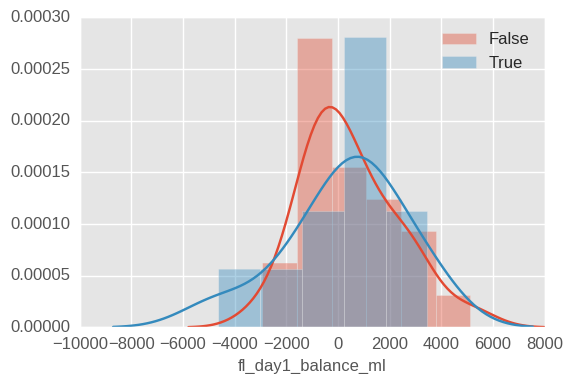

LV systolic: 1
468.257145224 1845.69086624
297.028088616 2305.71391462
Ttest_indResult(statistic=0.21654758616198369, pvalue=0.8312757362141785)
-0.0409726383099 0.815223968706



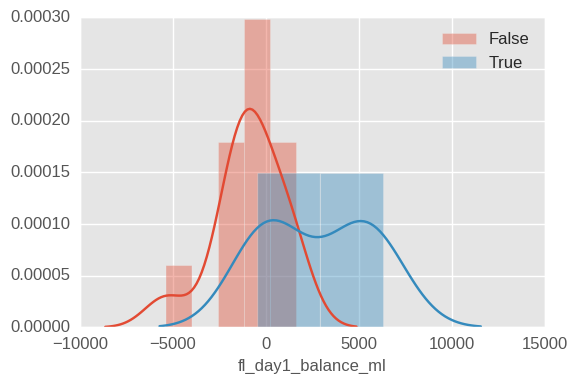

LV systolic: 2
-896.284005187 1868.77623526
2798.4099041 2853.57527217
Ttest_indResult(statistic=-3.2294393560527848, pvalue=0.0080207850762432208)
0.638069214405 0.00246852891588



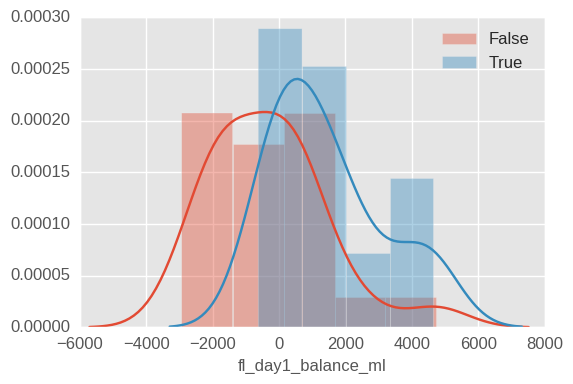

LV systolic: 3
-332.34294225 1756.42122504
1421.34820637 1673.91002941
Ttest_indResult(statistic=-3.3523637762080174, pvalue=0.0017317902256167544)
0.463410573066 0.00175068149799



,LV systolic,Pearson r,t-test p-value
0,-1,0.250621,0.090115
1,0,0.249370,0.000467
2,1,-0.040973,0.831276
3,2,0.638069,0.008021
4,3,0.463411,0.001732


In [56]:
statistics = []
for systolic_flag in [-1, 0, 1, 2, 3]:
    filter = (ef.mech_vent == 0) & (ef.ea_lv_systolic == systolic_flag)
    filter &= (ef.fb_day1_balance_ml >= -7000)
    group_0 = ef.loc[filter & (ef.day30_mortality == False)].fb_day1_balance_ml
    group_0 = group_0.dropna()
    group_1 = ef.loc[filter & (ef.day30_mortality == True)].fb_day1_balance_ml
    group_1 = group_1.dropna()

    f = plt.figure()
    sns.distplot(group_0, label='False')
    sns.distplot(group_1, label='True')
    plt.legend()
    display(f)
    plt.close()
    print('LV systolic:', systolic_flag)
    print(group_0.mean(), group_0.std())
    print(group_1.mean(), group_1.std())

    stats = {}
    ttest = ttest_ind(group_0, group_1, equal_var=False)
    print(ttest)
    stats['t-test p-value'] = ttest.pvalue
    data = ef.loc[filter,['fb_day1_balance_ml', 'day30_mortality']].dropna()
    r, pval = pearsonr(data.fb_day1_balance_ml, data.day30_mortality)
    print(r, pval)
    stats['Pearson r'] = r
    stats['LV systolic'] = systolic_flag
    statistics.append(stats)
    print('')
statistics = pd.DataFrame(statistics)
statistics

## Classification of 30-day mortality using LV systolic, congestive heart failure, fluid balance, and MDRD

In [71]:
## form the feature and target vectors
def make_features(data):
    mdrd = data.mdrd
    age = data.age_at_intime/np.timedelta64('1', 'Y')
    age.loc[age<0] = age.max()
    gender = data.gender == 'F'
    lv_sys = pd.get_dummies(data.ea_lv_systolic, dummy_na=True)
    features = lv_sys
    features['mdrd'] = mdrd
    features['age'] = age
    features['gender'] = gender
    features['congestive_heart_failure'] = ef.ex_congestive_heart_failure
    features['mech_vent'] = ef.mech_vent
    features['fluid1'] = ef.fb_day1_balance_ml
    features['fluid2'] = ef.fl_day2_balance_ml
    ## too many NaN in fluid3, remove
    #features['fluid3'] = ef.fl_day3_balance_ml 
    return features

In [72]:
x = make_features(ef)
y = ef.day30_mortality

In [73]:
x.head()

,-50.0,-1.0,0.0,1.0,2.0,3.0,nan,mdrd,age,gender,congestive_heart_failure,mech_vent,fluid1,fluid2
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,41.378665,35.312726,True,0,0,4740.000000,1354.000000
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,114.829574,28.333983,False,0,1,-1564.012497,-1546.220001
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,122.368229,68.902651,True,1,1,5742.809568,NaN
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,128.793511,82.609906,False,1,0,NaN,NaN
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,79.474706,88.886091,False,0,1,-248.250000,-465.499996


In [74]:
filter = ~np.isnan(x.fluid1.values) & ~np.isnan(x.fluid2.values)
x = x.iloc[filter]
y = y.iloc[filter]

In [75]:
## split into train and test
I = np.random.permutation(len(x))
n = int(0.1*len(x))
x_train = x.iloc[I[n:]]
y_train = y.iloc[I[n:]]
x_test = x.iloc[I[:n]]
y_test = y.iloc[I[:n]]

In [76]:
print(y_test.mean())
print(y_train.mean())
print(y.mean())

0.396226415094
0.413793103448
0.412041392286


In [77]:
from sklearn.ensemble import RandomForestClassifier

In [78]:
model = RandomForestClassifier()
model.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [79]:
print(model.score(x_train, y_train))
print(model.score(x_test, y_test))

0.972831765935
0.679245283019


In [80]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

      False       0.69      0.84      0.76        64
       True       0.64      0.43      0.51        42

avg / total       0.67      0.68      0.66       106



In [81]:
conf = pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['False', 'True'], index=['False', 'True'])
conf.index.name = 'Observed'
conf.columns.name = 'Predicted'
conf

Predicted,False,True
Observed,,
False,54,10
True,24,18


In [82]:
pd.DataFrame(pd.Series(model.feature_importances_, index=x.columns)).sort_values(0, ascending=False)

,0
fluid2,0.237201
fluid1,0.194891
mdrd,0.194258
age,0.194052
mech_vent,0.038268
gender,0.031760
congestive_heart_failure,0.025033
0.0,0.018093
-1.0,0.015738
NaN,0.014858


In [83]:
from sklearn.ensemble import GradientBoostingClassifier

In [84]:
model = GradientBoostingClassifier()
model.fit(x_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [85]:
print(model.score(x_train, y_train))
print(model.score(x_test, y_test))

0.817136886102
0.641509433962


In [86]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

      False       0.68      0.78      0.72        64
       True       0.56      0.43      0.49        42

avg / total       0.63      0.64      0.63       106



In [87]:
conf = pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['False', 'True'], index=['False', 'True'])
conf.index.name = 'Observed'
conf.columns.name = 'Predicted'
conf

Predicted,False,True
Observed,,
False,50,14
True,24,18


In [88]:
pd.DataFrame(pd.Series(model.feature_importances_, index=x.columns)).sort_values(0, ascending=False)

,0
mdrd,0.232620
age,0.228156
fluid2,0.210545
fluid1,0.208901
mech_vent,0.032726
3.0,0.029801
1.0,0.013988
gender,0.009330
-1.0,0.008979
2.0,0.006297


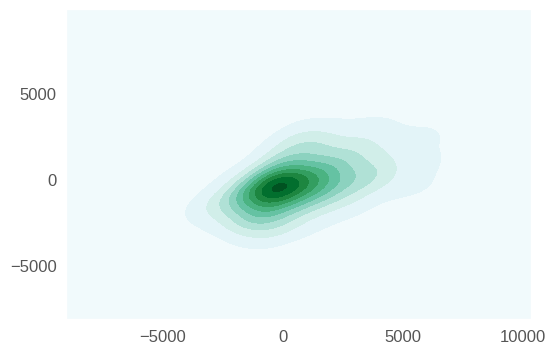

In [89]:
fluid1 = ef.fb_day1_balance_ml.values.copy()
fluid2 = ef.fl_day2_balance_ml.values.copy()
mask = np.isnan(fluid1) | np.isnan(fluid2)
mask |= (fluid1 < -7000) | (fluid2 < -7000) | (fluid1 > 8000) | (fluid2 > 8000)
fluid1 = fluid1[~mask]
fluid2 = fluid2[~mask]
sns.kdeplot(fluid1, fluid2, shade=True)

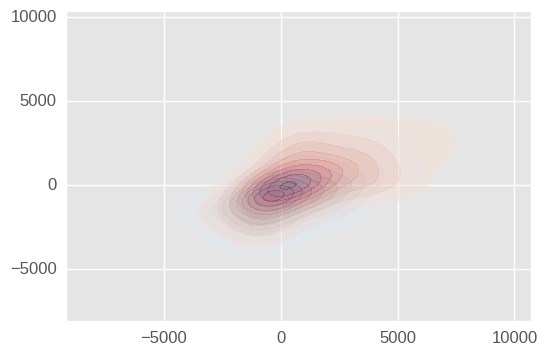

In [90]:
color = ['Blues', 'Reds']
i = 0
for name,group in ef.groupby('day30_mortality'):
    fluid1 = group.fb_day1_balance_ml.values.copy()
    fluid2 = group.fl_day2_balance_ml.values.copy()
    mask = np.isnan(fluid1) | np.isnan(fluid2)
    mask |= (fluid1 < -7000) | (fluid2 < -7000) | (fluid1 > 8000) | (fluid2 > 8000)
    fluid1 = fluid1[~mask]
    fluid2 = fluid2[~mask]
    sns.kdeplot(fluid1, fluid2, shade=True, label=str(name), cmap=color[i], lw=5, shade_lowest=False, alpha=0.33)
    i += 1